<h1>Detecting Fraudulent Transactions using  AI​</h1><br>



#Setup
#- Load libraries
#- Load common functions
#- Load stored datasets


In [2]:

# Load libraries and check memory

import psutil ; print(list(psutil.virtual_memory())[0:2])

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import xgboost as xgb

import pickle

import gc
gc.collect()
print(list(psutil.virtual_memory())[0:2])

[17020735488, 4339683328]
[17020735488, 4339531776]


In [3]:

# Load custom functions

import GAN

# For reloading after making changes
import importlib
importlib.reload(GAN) 
from GAN import *


In [ ]:

# Load engineered dataset from EDA section

data = pickle.load(open('credicard.engineered.pkl','rb'))

# data columns will be all other columns except class
data_cols = list(data.columns[ data.columns != 'Class' ])
label_cols = ['Class']

print(data_cols)
print('# of data columns: ',len(data_cols))


In [4]:

# Put columns in order of importance for xgboost fraud detection (from that section)


sorted_cols = ['V14', 'V4', 'V10', 'V17', 'Time', 'V12', 'V26', 'Amount', 'V21', 'V8', 'V11', 'V7', 'V28', 'V19', 'V3', 'V22', 'V6', 'V20', 'V27', 'V16', 'V13', 'V25', 'V24', 'V18', 'V2', 'V1', 'V5', 'V15', 'V9', 'V23', 'Class']

data = data[ sorted_cols ].copy()


In [5]:

# Add KMeans generated classes to fraud data - see classification section for more details on this

import sklearn.cluster as cluster

train = data.loc[ data['Class']==1 ].copy()

algorithm = cluster.KMeans
args, kwds = (), {'n_clusters':2, 'random_state':0}
labels = algorithm(*args, **kwds).fit_predict(train[ data_cols ])

print( pd.DataFrame( [ [np.sum(labels==i)] for i in np.unique(labels) ], columns=['count'], index=np.unique(labels) ) )

fraud_w_classes = train.copy()
fraud_w_classes['Class'] = labels


   count
0    357
1    135


In [6]:

# Function to create toy spiral dataset (looks like swiss roll)

def create_toy_spiral_df( n, seed=0):
    np.random.seed(seed)
    toy = np.array([ [ (i/10+1) * np.sin(i), -(i/10+1) * np.cos(i) ] for i in np.random.uniform(0,3*np.pi,size=n) ])
    toy = pd.DataFrame( toy, columns=[ ['v'+str(i+1) for i in range(2)] ])
    return toy



In [7]:

# Function to create toy dataset of multiple groups of normal distributions in n dimensions

def create_toy_df( n, n_dim, n_classes, seed=0):
    toy = pd.DataFrame(columns=[ ['v'+str(i+1) for i in range(n_dim)] + ['Class'] ])
    toy_cols = toy.columns
    np.random.seed(seed)
    for class0 in range(n_classes):
        center0s = np.random.randint(-10,10,size=n_dim)/10
        var0s = np.random.randint(1,3,size=n_dim)/10
        temp = np.array([[class0]]*n)
        for dim0 in range(n_dim):
            temp = np.hstack( [np.random.normal(center0s[dim0],var0s[dim0],n).reshape(-1,1), temp] )
        toy = pd.concat([toy,pd.DataFrame(temp,columns=toy_cols)],axis=0).reset_index(drop=True)
    return toy



<a id="EDA"><h1>Exploratory Data Analysis (EDA)</h1></a>



In [8]:

# Load the credit card data

data = pd.read_csv("data/creditcard.csv.zip")
print(data.shape)
print(data.columns)
data.head(3)

(284807, 31)
Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [9]:

# data columns will be all other columns except class

label_cols = ['Class']
data_cols = list(data.columns[ data.columns != 'Class' ])

print(data_cols)
print('# of data columns: ',len(data_cols))


['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']
# of data columns:  30


In [10]:

# 284315 normal transactions (class 0)
# 492 fraud transactions (class 1)

data.groupby('Class')['Class'].count()


Class
0    284315
1       492
Name: Class, dtype: int64

In [11]:

# Total nulls in dataset (sum over rows, then over columns)

data.isnull().sum().sum()


0

In [12]:

# Duplicates? Yes

normal_duplicates = sum( data.loc[ data.Class==0 ].duplicated() )
fraud_duplicates = sum( data.loc[ data.Class==1 ].duplicated() )
total_duplicates = normal_duplicates + fraud_duplicates

print( 'Normal duplicates', normal_duplicates )
print( 'Fraud duplicates', fraud_duplicates )
print( 'Total duplicates', total_duplicates )
print( 'Fraction duplicated', total_duplicates / len(data) )


Normal duplicates 1062
Fraud duplicates 19
Total duplicates 1081
Fraction duplicated 0.00379555277785


Last time value: 48.00


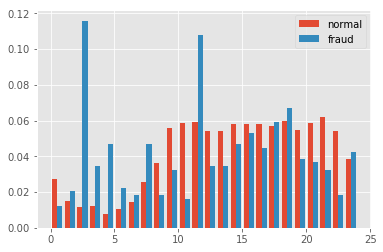

In [13]:


print( 'Last time value: {:.2f}'.format( data['Time'].max() / 3600 ) )

data['Time'] = ( data['Time'].values / 3600 ) % 24

plt.hist( [ data.loc[ data['Class']==0, 'Time'], data.loc[ data['Class']==1, 'Time'] ],
         normed=True, label=['normal','fraud'], bins=np.linspace(0,24,25))
plt.legend()
plt.show()




In [14]:

# several columns heavily skewed, 'Amount' the highest (besides Class)

data.skew()


Time      -0.499981
V1        -3.280667
V2        -4.624866
V3        -2.240155
V4         0.676292
V5        -2.425901
V6         1.826581
V7         2.553907
V8        -8.521944
V9         0.554680
V10        1.187141
V11        0.356506
V12       -2.278401
V13        0.065233
V14       -1.995176
V15       -0.308423
V16       -1.100966
V17       -3.844914
V18       -0.259880
V19        0.109192
V20       -2.037155
V21        3.592991
V22       -0.213258
V23       -5.875140
V24       -0.552499
V25       -0.415793
V26        0.576693
V27       -1.170209
V28       11.192091
Amount    16.977724
Class     23.997579
dtype: float64

In [15]:
# Minimum 'Amount' is 0
# 0's account for 0.6% of the data set

print( data['Amount'].min() )
print( np.sum( data['Amount']==0 ) )
print( np.sum( data['Amount']==0 ) / len(data) )

0.0
1825
0.00640784812171


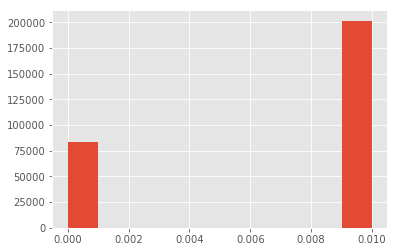

In [16]:
# Looks like all 'Amount' values are rounded to the hundredths (0.01) place
data['Amount'].mod(0.01).hist() ;

In [17]:

# Some values are much more frequent than others
# 0.00 comes in 12th in the list

print( data.Amount.value_counts().head(15) )


1.00     13688
1.98      6044
0.89      4872
9.99      4747
15.00     3280
0.76      2998
10.00     2950
1.29      2892
1.79      2623
0.99      2304
20.00     2002
0.00      1825
8.99      1811
11.50     1741
4.49      1579
Name: Amount, dtype: int64


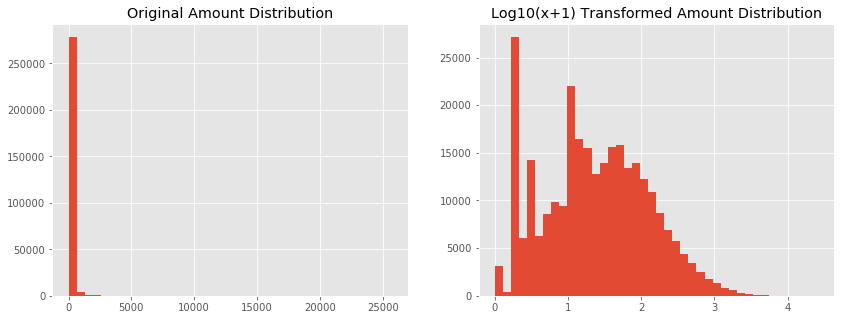

In [18]:
# Log transform amount values to give more normal distribution

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.hist(data['Amount'], bins=40)
plt.title('Original Amount Distribution')

plt.subplot(1,2,2)
d0 = np.log10( data['Amount'].values + 1 )
plt.hist( d0, bins=40 )
plt.title('Log10(x+1) Transformed Amount Distribution')
plt.show()

In [19]:

# Use log transformed data

data['Amount'] = d0


In [21]:

# Center and scale all data, only using the middle 99.8%, so outliers don't pull too much.
# First generate the percentile data for each feature

percentiles =  pd.DataFrame( np.array([ np.percentile( data[i], [ 0.1, 99.9 ] ) for i in data_cols ]).T,
                            columns=data_cols, index=['min','max'] )

percentile_means = \
    [ [ np.mean( data.loc[ (data[i]>percentiles[i]['min']) & (data[i]<percentiles[i]['max']) , i ] ) ]
     for i in data_cols ]

percentiles = percentiles.append( pd.DataFrame(np.array(percentile_means).T, columns=data_cols, index=['mean']) )

percentile_stds = \
    [ [ np.std( data.loc[ (data[i]>percentiles[i]['min']) & (data[i]<percentiles[i]['max']) , i ] ) ]
     for i in data_cols ]

percentiles = percentiles.append( pd.DataFrame(np.array(percentile_stds).T, columns=data_cols, index=['stdev']) )

percentiles


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
min,0.025833,-16.044343,-15.126221,-9.870326,-4.163262,-9.408512,-5.290163,-9.365179,-13.102174,-3.305247,...,-6.621889,-5.490204,-3.119845,-5.452756,-2.001248,-2.403083,-1.276676,-3.823857,-2.629030,0.000000
max,23.965278,2.344685,7.852129,3.387393,6.235906,8.074611,6.164944,7.972745,6.135087,5.960836,...,5.809376,7.879007,2.260348,4.759942,1.246819,1.873743,2.251097,2.607462,2.095818,3.477266
mean,14.543063,0.020195,0.012756,0.011923,-0.003827,0.002532,-0.000677,0.001153,0.011022,-0.002363,...,0.002214,-0.002930,0.001083,0.002081,0.000089,0.000504,-0.001117,0.001314,-0.000914,1.375513
stdev,5.827070,1.814661,1.429787,1.419404,1.383725,1.208541,1.263637,1.018486,0.956445,1.064801,...,0.595668,0.550113,0.704365,0.433626,0.596816,0.505554,0.474011,0.330955,0.223416,0.710045


In [22]:

# Center and scale the data using the percentile data we just generated

data[data_cols] = ( data[data_cols] - percentiles.loc[ 'mean', data_cols ] ) / percentiles.loc[ 'stdev', data_cols ]


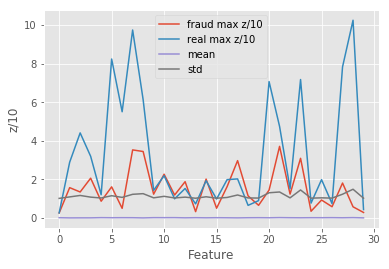

In [24]:
# There are outliers, 50-100 stdevs away from mean in several columns

plot_cols = data_cols

plt.plot( data.loc[ data.Class==1, plot_cols ].abs().max().values / data[ plot_cols ].std().values / 10, label='fraud max z/10' )
plt.plot( data.loc[ data.Class==0, plot_cols ].abs().max().values / data[ plot_cols ].std().values / 10, label='real max z/10' )
plt.plot( data[ plot_cols ].mean().values, label='mean' )
plt.plot( data[ plot_cols ].std().values, label='std' )
plt.xlabel('Feature')
plt.ylabel('z/10')
plt.legend() ; 


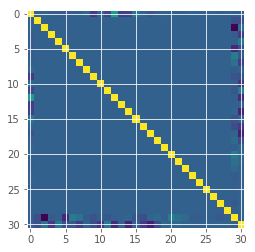

In [25]:
# Check Correlations
# Note no correlations among PCA transformed columns, as expected
corr0 = data.corr()
plt.imshow(corr0) ;

<a id="Fig3"><h1>Figure 3: Data Distributions by Feature and Class</h1></a><br>
<a href='#TOC'>Table of contents</a>

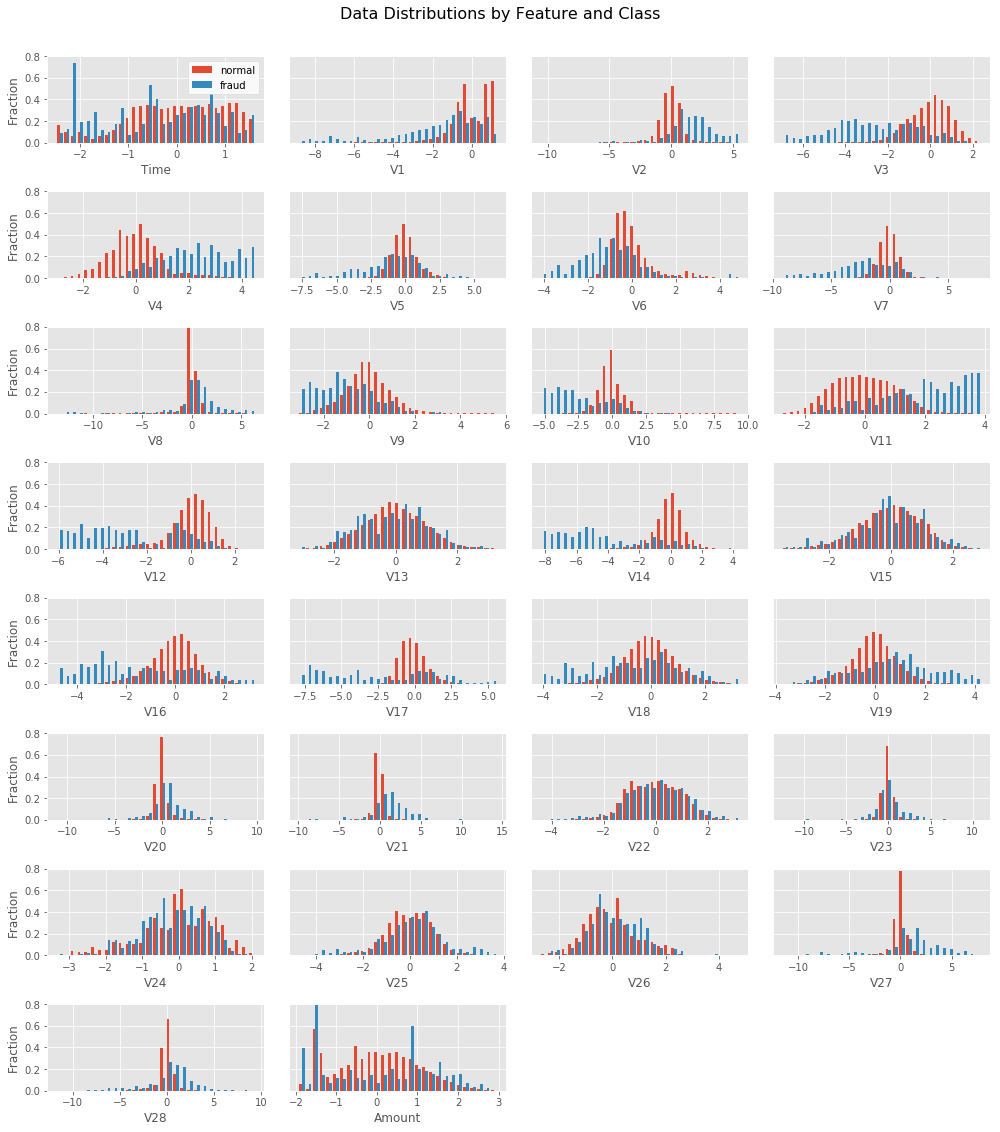

In [27]:

# Plot the data by each feature

axarr = [[]]*len(data_cols)
columns = 4
rows = int( np.ceil( len(data_cols) / columns ) )
f, fig = plt.subplots( figsize=(columns*3.5, rows*2) )

f.suptitle('Data Distributions by Feature and Class', size=16)

for i, col in enumerate(data_cols[:]):
    axarr[i] = plt.subplot2grid( (int(rows), int(columns)), (int(i//columns), int(i%columns)) )
    axarr[i].hist( [ data.loc[ data.Class == 0, col ], data.loc[ data.Class == 1, col ] ], label=['normal','fraud'], 
                          bins=np.linspace( np.percentile(data[col],0.1), np.percentile(data[col],99.9), 30 ),
                          normed=True )
    axarr[i].set_xlabel(col, size=12)
    axarr[i].set_ylim([0,0.8])
    axarr[i].tick_params(axis='both', labelsize=10)
    if i == 0: 
        legend = axarr[i].legend()
        legend.get_frame().set_facecolor('white')
    if i%4 != 0 : 
        axarr[i].tick_params(axis='y', left='off', labelleft='off')
    else:
        axarr[i].set_ylabel('Fraction',size=12)

plt.tight_layout(rect=[0,0,1,0.95]) # xmin, ymin, xmax, ymax
plt.show()

In [28]:

# Save engineered dataset for use in analysis
# Save as pickle for faster reload

pickle.dump(data, open('credicard.engineered.pkl','wb'))


In [26]:

# # Save as csv for human readability - much slower save

# data.to_csv('data/' + 'credicard.engineered.csv.zip')


<a id="xgboost fraud detection"><h1>xgboost fraud detection</h1></a>


- Here we'll use the xgboost algorithm to detect fraud cases

In [ ]:

# define the columns we want to test on, in case we want to use less than the full set

test_cols = data.columns


print(len(test_cols))
print(test_cols)

In [57]:

# Define some custom metric functions for use with the xgboost algorithm

from sklearn.metrics import recall_score, precision_score, roc_auc_score

def recall(preds, dtrain):
    labels = dtrain.get_label()
    return 'recall',  recall_score(labels, np.round(preds))

def precision(preds, dtrain):
    labels = dtrain.get_label()
    return 'precision',  precision_score(labels, np.round(preds))

def roc_auc(preds, dtrain):
    labels = dtrain.get_label()
    return 'roc_auc',  roc_auc_score(labels, preds)


In [58]:
# Set up the test and train sets

np.random.seed(0)

n_real = np.sum(data.Class==0) # 200000
n_test = np.sum(data.Class==1) # 492
train_fraction = 0.7
fn_real = int(n_real * train_fraction)
fn_test = int(n_test * train_fraction)

real_samples = data.loc[ data.Class==0, test_cols].sample(n_real, replace=False).reset_index(drop=True)
test_samples = data.loc[ data.Class==1, test_cols].sample(n_test, replace=False).reset_index(drop=True)

train_df = pd.concat([real_samples[:fn_real],test_samples[:fn_test]],axis=0,ignore_index=True).reset_index(drop=True)

test_df = pd.concat([real_samples[fn_real:],test_samples[fn_test:]],axis=0,ignore_index=True).reset_index(drop=True)
print( 'classes 0, 1: ', n_real, n_test )
print( 'train, test: ', len(train_df), len(test_df) )

X_col = test_df.columns[:-1]
y_col = test_df.columns[-1]
dtrain = xgb.DMatrix(train_df[X_col], train_df[y_col], feature_names=X_col)
dtest = xgb.DMatrix(test_df[X_col], test_df[y_col], feature_names=X_col)


classes 0, 1:  284315 492
train, test:  199364 85443


In [60]:

# Run the xgboost algorithm, maximize recall on the test set


results_dict = {}

xgb_params = {
    'objective': 'binary:logistic',
    'random_state': 0,
    'eval_metric': 'auc', # auc, error

}

xgb_test = xgb.train(xgb_params, dtrain, num_boost_round=100, 
                     verbose_eval=False,
                     early_stopping_rounds=20, 
                     evals=[(dtrain,'train'),(dtest,'test')],
                     evals_result = results_dict,              
                     feval = recall, maximize=True
                     
                    )

y_pred = xgb_test.predict(dtest, ntree_limit=xgb_test.best_iteration+1)
y_true = test_df['Class'].values
print( 'best iteration: ', xgb_test.best_iteration )
print( recall( y_pred, dtest ) )
print( precision( y_pred, dtest ) )
print( roc_auc( y_pred, dtest ) )
SimpleMetrics( np.round(y_pred), y_true)

best iteration:  31
('recall', 0.76351351351351349)
('precision', 0.94166666666666665)
('roc_auc', 0.97648978188576063)
Confusion Matrix


,Pred 0,Pred 1
True 0,85288,7
True 1,35,113


Accuracy : 0.9995084442259752


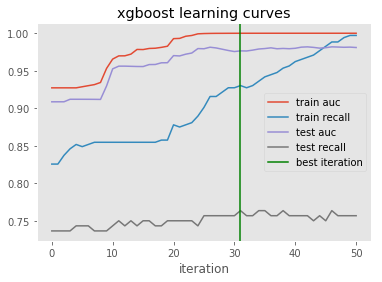

In [61]:

# Let's look at how the metrics changed on the train and test sets as more trees were added

for i in results_dict:
    for err in results_dict[i]:
        plt.plot(results_dict[i][err], label=i+' '+err)   
plt.axvline(xgb_test.best_iteration, c='green', label='best iteration')
plt.xlabel('iteration')
# plt.ylabel(err)
plt.title('xgboost learning curves')
plt.legend()
plt.grid() ;

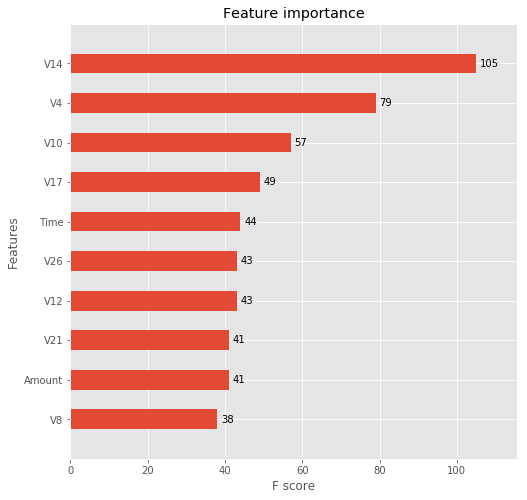

In [62]:
# Plot feature importances

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
xgb.plot_importance(xgb_test, max_num_features=10, height=0.5, ax=ax);

In [65]:

# Generate list of features sorted by importance in detecting fraud

import operator
x = xgb_test.get_fscore()
sorted_x = sorted(x.items(), key=operator.itemgetter(1), reverse=True)


sorted_cols = [i[0] for i in sorted_x] + ['Class']
print( sorted_cols )


['V14', 'V4', 'V10', 'V17', 'Time', 'V12', 'V26', 'Amount', 'V21', 'V8', 'V11', 'V7', 'V28', 'V19', 'V3', 'V22', 'V6', 'V20', 'V27', 'V16', 'V13', 'V25', 'V24', 'V18', 'V2', 'V1', 'V5', 'V15', 'V9', 'V23', 'Class']


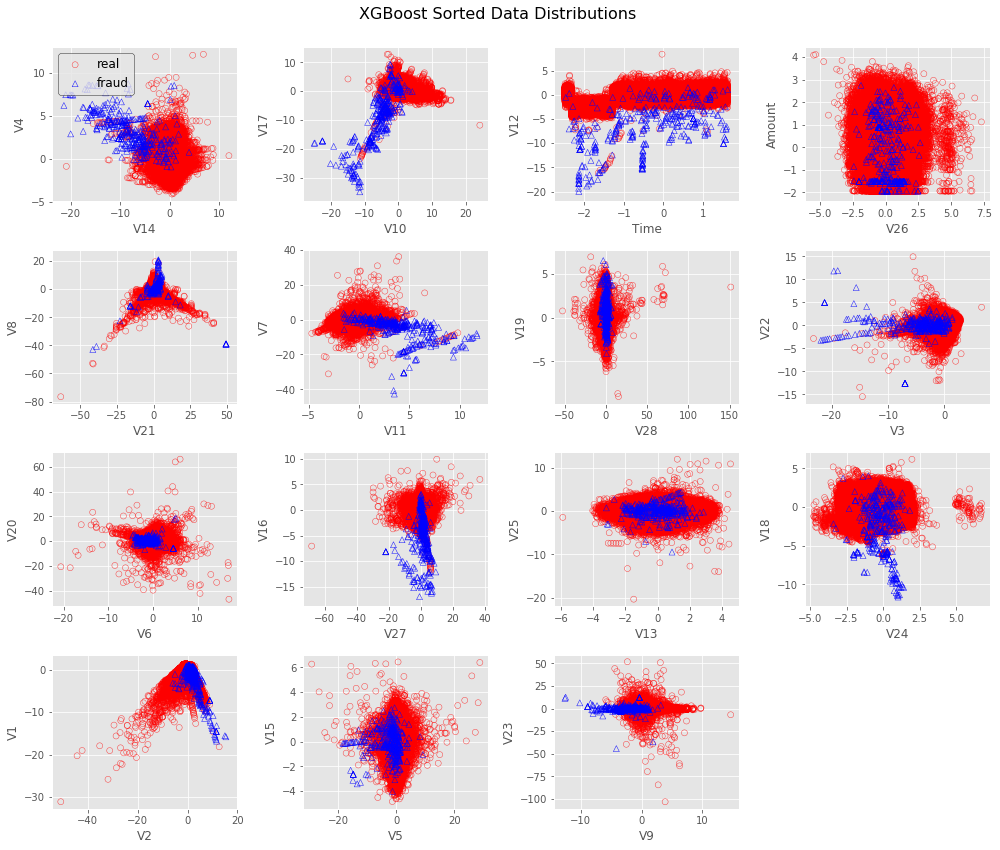

In [64]:

# Plot all of the training data with paired features sorted by importance


colors = ['red','blue']
markers = ['o','^']
labels = ['real','fraud']
alphas = [0.7, 0.9]

columns = 4
rows = int( np.ceil( len(data_cols) / columns / 2 ) )
plt.figure( figsize=(columns*3.5, rows*3) )
plt.suptitle('XGBoost Sorted Data Distributions ', size=16)

train = train_df.copy()

for i in range( int(np.floor(len(sorted_x)/2)) )[:]:
    col1, col2 = sorted_x[i*2][0], sorted_x[i*2+1][0]
    
    plt.subplot(rows,columns,i+1)  
    for group, color, marker, label, alpha in zip( train.groupby('Class'), colors, markers, labels, alphas ):
        plt.scatter( group[1][col1], group[1][col2], 
                         label=label, marker=marker, alpha=alpha,
                         edgecolors=color, facecolors='none' )         
    plt.xlabel(col1, size=12)
    plt.ylabel(col2, size=12)
    plt.tick_params(axis='both', labelsize=10)
    if i == 0: plt.legend(fontsize=12, edgecolor='black')

plt.tight_layout(rect=[0,0,1,0.95]) # xmin, ymin, xmax, ymax
plt.show()


In [47]:


# Lets look at the effect of the ratio of normal:fraud data in the dataset on recall and roc_auc
# We'll use cross validation to see if differences are significant


np.random.seed(0)

n_real = np.sum(data.Class==0) # 200000
n_test = np.sum(data.Class==1) # 492
real_samples = data.loc[ data.Class==0, test_cols].sample(n_real, replace=False).reset_index(drop=True)
test_samples = data.loc[ data.Class==1, test_cols].sample(n_test, replace=False).reset_index(drop=True)
X_col = data.columns[:-1]
y_col = data.columns[-1]

test_data=[]


for i in np.logspace(-1,2,8):
    print(i)
    train_df = pd.concat([real_samples[:int(n_test*i)],test_samples[:n_test]],axis=0,ignore_index=True).reset_index(drop=True)
    dtrain = xgb.DMatrix(train_df[X_col], train_df[y_col], feature_names=X_col)
    results = xgb.cv(xgb_params, dtrain, 
                     nfold=5, num_boost_round=100, early_stopping_rounds=10, seed=0,
                     feval=recall)
    test_data.append(list([i]) + list(results.tail(1).index) + list(results.tail(1).values[0]))
    
test_data = pd.DataFrame(test_data, columns=list(['ratio','best'])+list(results.columns))
test_data

0.1
0.268269579528
0.719685673001
1.93069772888
5.17947467923
13.8949549437
37.2759372031
100.0


,ratio,best,test-auc-mean,test-auc-std,test-recall-mean,test-recall-std,train-auc-mean,train-auc-std,train-recall-mean,train-recall-std
0,0.100000,0,0.926863,0.100034,0.963573,0.011458,0.994500,0.005659,0.986232,0.003142
1,0.268270,0,0.955194,0.028065,0.932319,0.027374,0.995613,0.002483,0.975911,0.008158
2,0.719686,0,0.966428,0.009332,0.906090,0.016959,0.994125,0.001611,0.964925,0.008057
3,1.930698,1,0.965753,0.016769,0.872036,0.022528,0.988298,0.003793,0.932345,0.007102
4,5.179475,0,0.949072,0.004681,0.851627,0.026320,0.962013,0.002299,0.892954,0.010674
5,13.894955,0,0.940607,0.014988,0.839945,0.034323,0.954365,0.002892,0.871941,0.006559
6,37.275937,0,0.922151,0.029086,0.824434,0.056648,0.930331,0.006133,0.841479,0.015422
7,100.000000,0,0.916909,0.025283,0.803685,0.046228,0.922589,0.006383,0.825135,0.009177


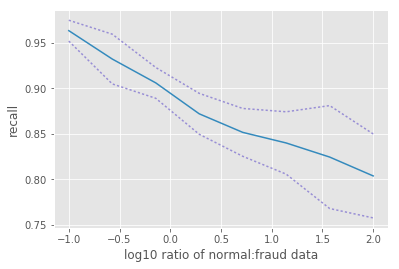

In [52]:

# Recall decreases as more normal data is added


metric = 'recall'

xs = np.log10(test_data['ratio'].values)
ys = test_data['test-'+metric+'-mean'].values
stds = test_data['test-'+metric+'-std'].values
plt.plot(xs,ys,c='C1')
plt.plot(xs,ys+stds,linestyle=':',c='C2')
plt.plot(xs,ys-stds,linestyle=':',c='C2')
plt.xlabel('log10 ratio of normal:fraud data')
plt.ylabel(metric)

plt.show()

<a id="Classification"><h1>Classification</h1></a>


In [ ]:

# load clustering libraries

import sklearn.cluster as cluster


In [67]:

# hdbscan not in kaggle/python at present

!pip install hdbscan
import hdbscan


In [66]:

# Set up training set to consist of only fraud data

train = data.loc[ data['Class']==1 ].copy()

print( pd.DataFrame( [ [np.sum(train['Class']==i)] for i in np.unique(train['Class']) ], columns=['count'], index=np.unique(train['Class']) ) )

label_cols = [ i for i in train.columns if 'Class' in i ]
data_cols = [ i for i in train.columns if i not in label_cols ]
train_no_label = train[ data_cols ]


   count
1    492


In [68]:
%%time

# Create multiple projections to compare results from different random states

from sklearn.manifold import TSNE

projections = [ TSNE(random_state=i).fit_transform(train_no_label) for i in range(3) ]


CPU times: user 7.23 s, sys: 1.2 s, total: 8.43 s
Wall time: 7.82 s


0 KMeans
1 Agglomerative
2 HDBSCAN


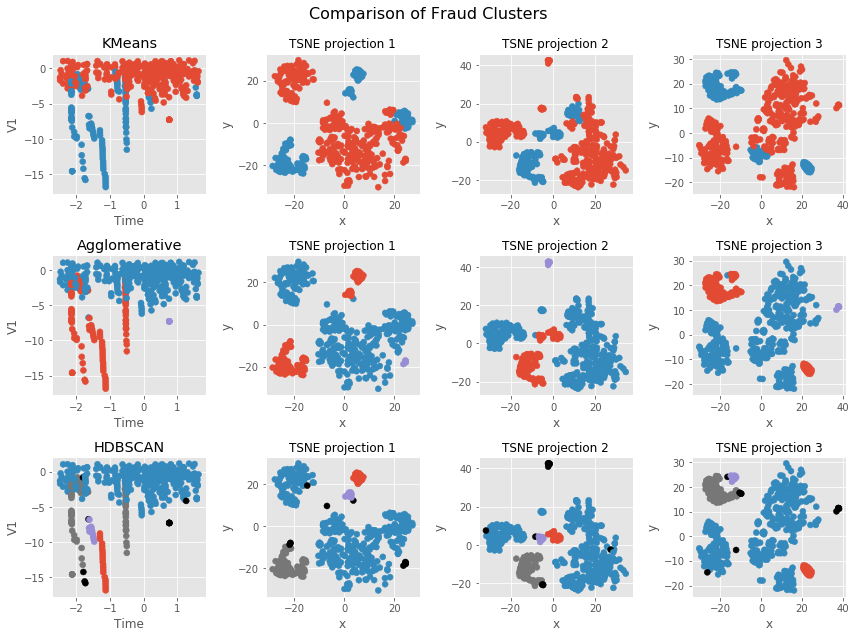

CPU times: user 4.04 s, sys: 3.13 s, total: 7.17 s
Wall time: 3.72 s


In [69]:
%%time 


algorithms = [ 
    [ 'KMeans', cluster.KMeans, (), {'n_clusters':2, 'random_state':0} ],
    [ 'Agglomerative', cluster.AgglomerativeClustering, (), {'linkage': 'ward', 'n_clusters': 3} ],

    [ 'HDBSCAN', hdbscan.HDBSCAN, (), {'min_cluster_size':10, 'min_samples':1, } ],

]

rows = len(algorithms)
columns = 4
plt.figure(figsize=(columns*3, rows*3))

for i, [name, algorithm, args, kwds] in enumerate(algorithms):
    print(i, name)

    labels = algorithm(*args, **kwds).fit_predict(train_no_label)

    
    colors = np.clip(labels,-1,9)
    colors = [ 'C'+str(i) if i>-1 else 'black' for i in colors ]
    
    plt.subplot(rows,columns,i*columns+1)
    plt.scatter(train_no_label[data_cols[0]], train_no_label[data_cols[1]], c=colors)
    plt.xlabel(data_cols[0]), plt.ylabel(data_cols[1])
    plt.title(name)

    for j in range(3):
        plt.subplot(rows,columns,i*columns+1+j+1)
        plt.scatter(*(projections[j].T), c=colors) 
        plt.xlabel('x'), plt.ylabel('y')
        plt.title('TSNE projection '+str(j+1),size=12)
        

plt.suptitle('Comparison of Fraud Clusters', size=16)
plt.tight_layout(rect=[0,0,1,0.95])
plt.savefig('plots/Fraud_Cluster_Diagram.png')
plt.show()

In [70]:


algorithm = cluster.KMeans
args, kwds = (), {'n_clusters':2, 'random_state':0}
labels = algorithm(*args, **kwds).fit_predict(train_no_label)

print( pd.DataFrame( [ [np.sum(labels==i)] for i in np.unique(labels) ], columns=['count'], index=np.unique(labels) ) )

fraud_w_classes = train.copy()
fraud_w_classes['Class'] = labels


   count
0    357
1    135


In [76]:


dtrain = xgb.DMatrix(fraud_w_classes[data_cols], fraud_w_classes['Class'], feature_names=data_cols)

xgb_params = {
    'objective': 'binary:logistic',
    'random_state': 0,
    'eval_metric': 'auc', # allows for balanced or unbalanced classes 
    }
xgb_test = xgb.train(xgb_params, dtrain, num_boost_round=10) # limit to ten rounds for fast evaluation

import operator
x = xgb_test.get_fscore()
sorted_x = sorted(x.items(), key=operator.itemgetter(1), reverse=True)
print( 'Top eight features: ', [ [i[0],i[1]] for i in sorted_x[:8] ] )


Top eight features:  [['V17', 10], ['V7', 5], ['V10', 5], ['V4', 2], ['V3', 2], ['V6', 1], ['V11', 1], ['V15', 1]]


<a id="GAN setup"><h1>GAN setup and training</h1></a>

<a href='#TOC'>Table of contents</a>


Conversion of Waya.ai GAN and WGAN
- Remove convolutional layers
- Remove ResNeXt
- Add simple dense networks
- Convert WGAN back to simple GAN
- Use common functions as much as possible


In [78]:


# reloading the libraries and setting the parameters


import GAN
import importlib
importlib.reload(GAN) # For reloading after making changes
from GAN import *

rand_dim = 32 # 32 # needs to be ~data_dim
base_n_count = 128 # 128

nb_steps = 500 + 1 # 50000 # Add one for logging of the last interval
batch_size = 128 # 64

k_d = 1  # number of critic network updates per adversarial training step
k_g = 1  # number of generator network updates per adversarial training step
critic_pre_train_steps = 100 # 100  # number of steps to pre-train the critic before starting adversarial training
log_interval = 100 # 100  # interval (in steps) at which to log loss summaries and save plots of image samples to disc
learning_rate = 5e-4 # 5e-5
data_dir = 'cache/'
generator_model_path, discriminator_model_path, loss_pickle_path = None, None, None

show = True 


train = fraud_w_classes.copy().reset_index(drop=True) # fraud only with labels from classification

label_cols = [ i for i in train.columns if 'Class' in i ]
data_cols = [ i for i in train.columns if i not in label_cols ]
train[ data_cols ] = train[ data_cols ] / 10 # scale to random noise size, one less thing to learn
train_no_label = train[ data_cols ]

data_dim:  30
data_cols:  ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               4224      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_4 (Dense)              (None, 30)                15390     
Total params: 184,222
Trainable params: 18

/opt/conda/lib/python3.6/site-packages/Keras-2.0.4-py3.6.egg/keras/backend/tensorflow_backend.py:2289: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


Step: 0 of 501.
Losses: G, D Gen, D Real, Xgb: 0.6706, 0.7378, 0.6531, 0.9878
D Real - D Gen: -0.0846


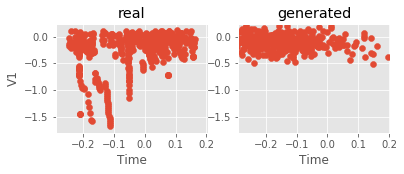

Step: 100 of 501.
Losses: G, D Gen, D Real, Xgb: 0.9945, 0.6006, 0.7227, 0.9878
D Real - D Gen: 0.1221


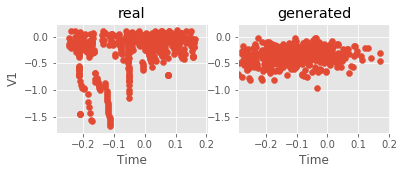

Step: 200 of 501.
Losses: G, D Gen, D Real, Xgb: 0.9677, 0.6588, 0.5321, 0.9878
D Real - D Gen: -0.1267


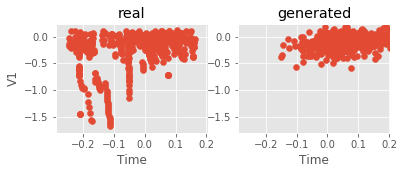

Step: 300 of 501.
Losses: G, D Gen, D Real, Xgb: 1.0075, 0.7025, 0.6853, 0.9817
D Real - D Gen: -0.0172


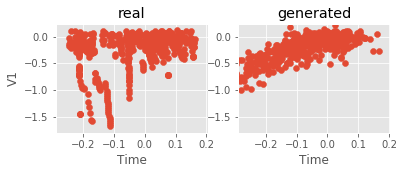

Step: 400 of 501.
Losses: G, D Gen, D Real, Xgb: 0.9930, 0.6215, 0.7477, 0.9472
D Real - D Gen: 0.1262


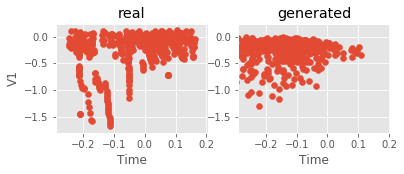

Step: 500 of 501.
Losses: G, D Gen, D Real, Xgb: 1.6672, 0.4173, 0.5418, 0.9797
D Real - D Gen: 0.1245


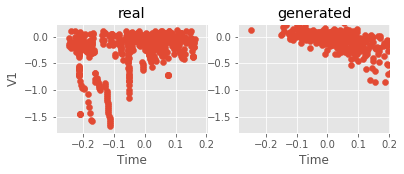

data_dim:  30
data_cols:  ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']
label_dim:  1
label_cols:  ['Class']
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 32)            0                                            
____________________________________________________________________________________________________
input_4 (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
concatenate_1 (Concatenate)      (None, 33)            0           input_3[0][0]                    
                        

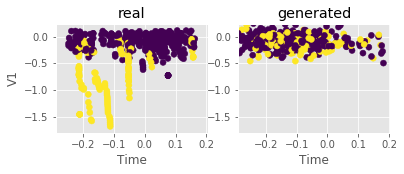

Step: 100 of 501.
Losses: G, D Gen, D Real, Xgb: 1.3992, 0.7085, 0.3819, 1.0000
D Real - D Gen: -0.3267


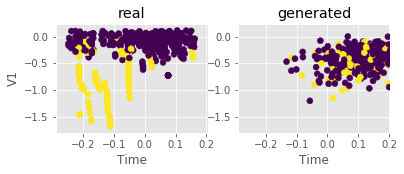

Step: 200 of 501.
Losses: G, D Gen, D Real, Xgb: 1.2793, 0.6143, 0.8715, 0.9939
D Real - D Gen: 0.2572


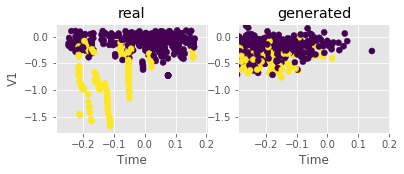

Step: 300 of 501.
Losses: G, D Gen, D Real, Xgb: 0.8460, 0.8424, 0.5973, 0.9533
D Real - D Gen: -0.2451


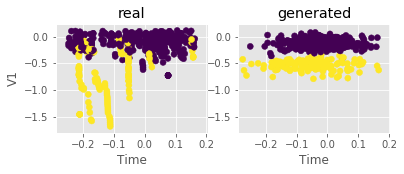

Step: 400 of 501.
Losses: G, D Gen, D Real, Xgb: 0.9452, 0.6505, 0.6503, 0.9634
D Real - D Gen: -0.0002


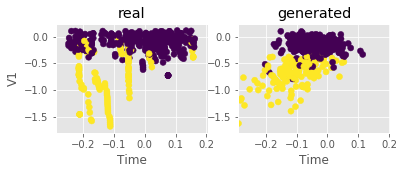

Step: 500 of 501.
Losses: G, D Gen, D Real, Xgb: 1.0164, 0.6773, 0.5915, 0.9939
D Real - D Gen: -0.0858


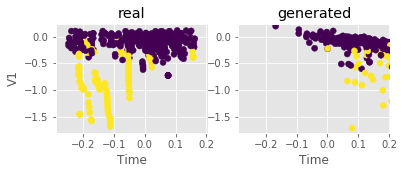

CPU times: user 1min 47s, sys: 30.8 s, total: 2min 18s
Wall time: 1min 21s


In [79]:
%%time

# Training the vanilla GAN and CGAN architectures

k_d = 1  # number of critic network updates per adversarial training step
learning_rate = 5e-4 # 5e-5
arguments = [rand_dim, nb_steps, batch_size, 
             k_d, k_g, critic_pre_train_steps, log_interval, learning_rate, base_n_count,
            data_dir, generator_model_path, discriminator_model_path, loss_pickle_path, show ]

adversarial_training_GAN(arguments, train_no_label, data_cols ) # GAN
adversarial_training_GAN(arguments, train, data_cols=data_cols, label_cols=label_cols ) # CGAN

data_dim:  30
data_cols:  ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 32)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 128)               4224      
_________________________________________________________________
dense_18 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_19 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_20 (Dense)             (None, 30)                15390     
Total params: 184,222
Trainable params: 18

/opt/conda/lib/python3.6/site-packages/Keras-2.0.4-py3.6.egg/keras/backend/tensorflow_backend.py:2289: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


Step: 0 of 501.
Losses: G, D Gen, D Real, Xgb: 0.0105, -0.0096, 0.0719, 0.9898
D Real - D Gen: 0.0815


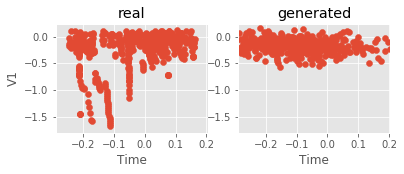

Step: 100 of 501.
Losses: G, D Gen, D Real, Xgb: 0.0207, -0.0268, 0.0615, 0.8252
D Real - D Gen: 0.0883


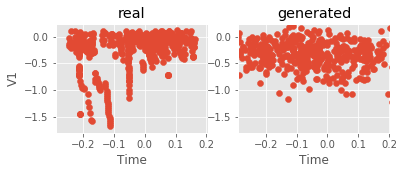

Step: 200 of 501.
Losses: G, D Gen, D Real, Xgb: -0.0112, 0.0065, 0.0846, 0.8150
D Real - D Gen: 0.0781


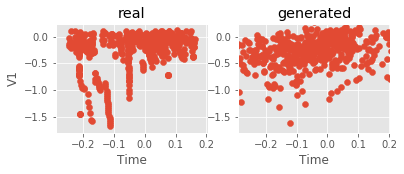

Step: 300 of 501.
Losses: G, D Gen, D Real, Xgb: 0.0032, -0.0021, 0.0841, 0.8191
D Real - D Gen: 0.0861


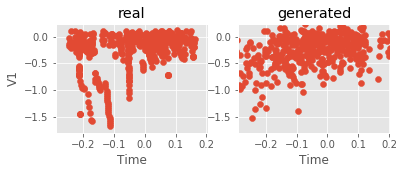

Step: 400 of 501.
Losses: G, D Gen, D Real, Xgb: 0.0190, -0.0187, 0.0517, 0.7825
D Real - D Gen: 0.0705


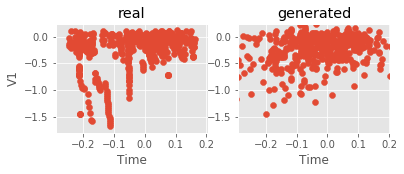

Step: 500 of 501.
Losses: G, D Gen, D Real, Xgb: 0.0446, -0.0472, 0.0322, 0.8110
D Real - D Gen: 0.0794


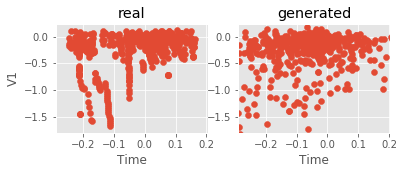

data_dim:  30
data_cols:  ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']
label_dim:  1
label_cols:  ['Class']
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_8 (InputLayer)             (None, 32)            0                                            
____________________________________________________________________________________________________
input_9 (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
concatenate_3 (Concatenate)      (None, 33)            0           input_8[0][0]                    
                        

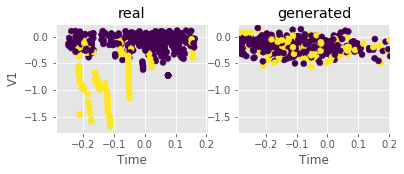

Step: 100 of 501.
Losses: G, D Gen, D Real, Xgb: 0.0127, -0.0177, 0.0848, 0.9065
D Real - D Gen: 0.1025


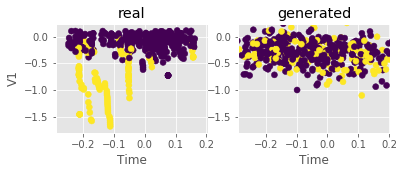

Step: 200 of 501.
Losses: G, D Gen, D Real, Xgb: -0.0332, 0.0325, 0.1311, 0.8455
D Real - D Gen: 0.0987


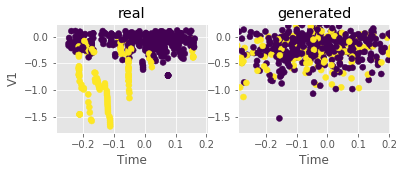

Step: 300 of 501.
Losses: G, D Gen, D Real, Xgb: -0.0387, 0.0367, 0.1347, 0.8394
D Real - D Gen: 0.0980


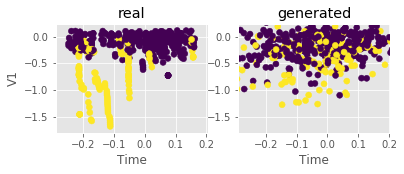

Step: 400 of 501.
Losses: G, D Gen, D Real, Xgb: -0.0195, 0.0307, 0.1077, 0.7866
D Real - D Gen: 0.0770


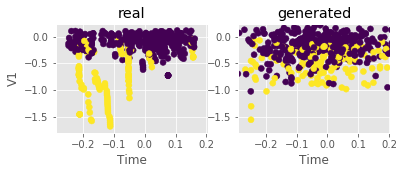

Step: 500 of 501.
Losses: G, D Gen, D Real, Xgb: -0.0059, 0.0228, 0.1061, 0.8394
D Real - D Gen: 0.0833


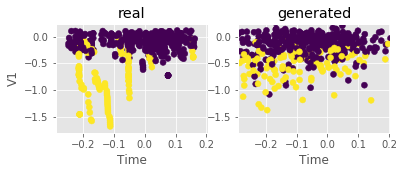

CPU times: user 7min 48s, sys: 2min 3s, total: 9min 51s
Wall time: 5min 24s


In [80]:
%%time

# Training the WGAN and WCGAN architectures

k_d = 5 # train critic to optimal state each time
learning_rate = 1e-4 # 5e-5
arguments = [rand_dim, nb_steps, batch_size, 
             k_d, k_g, critic_pre_train_steps, log_interval, learning_rate, base_n_count,
            data_dir, generator_model_path, discriminator_model_path, loss_pickle_path, show ]

adversarial_training_WGAN(arguments, train_no_label, data_cols=data_cols ) # WGAN
adversarial_training_WGAN(arguments, train, data_cols=data_cols, label_cols=label_cols ) # WCGAN

In [82]:

# For reloading loss data from pickles

prefix = 'WCGAN'
step = 500

[combined_loss, disc_loss_generated, disc_loss_real, xgb_losses] = pickle.load(
    open(data_dir+prefix+'_losses_step_'+str(step)+'.pkl','rb'))


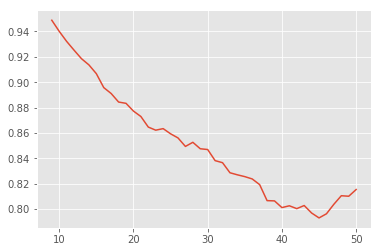

In [84]:
# plt.plot( xgb_losses[:] ) ;
w = 10
plt.plot( pd.DataFrame(xgb_losses[:]).rolling(w).mean() ) ;

In [85]:

# Look for the step with the lowest xgboost accuracy, and the lowest step saved (every 100)

best_step = list(xgb_losses).index( xgb_losses.min() ) * 10
print( best_step, xgb_losses.min() )

xgb100 = [ xgb_losses[i] for i in range(0, len(xgb_losses), 10) ]
best_step = xgb100.index( min(xgb100) ) * log_interval
print( best_step, min(xgb100) )

380 0.758130081301
400 0.786585365854


In [86]:

# Look for the step with the lowest critic loss, and the lowest step saved (every 100)

delta_losses = np.array(disc_loss_real) - np.array(disc_loss_generated)

best_step = list(delta_losses).index( delta_losses.min() )
print( best_step, delta_losses.min() )

delta100 = [ delta_losses[i] for i in range(0, len(delta_losses), 100) ]
best_step = delta100.index( min(delta100) ) * log_interval
print( best_step, min(delta100) )

484 0.0538803
0 0.0592695


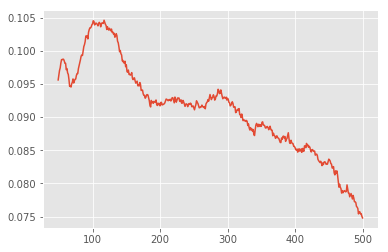

In [87]:

w = 50
plt.plot( pd.DataFrame(disc_loss_real[:]).rolling(w).mean() - pd.DataFrame(disc_loss_generated[:]).rolling(w).mean() ) ;


In [88]:
# Let's look at some of the generated data
# First create the networks locally and load the weights

import GAN
import importlib
importlib.reload(GAN) # For reloading after making changes
from GAN import *

seed = 17

train = fraud_w_classes.copy().reset_index(drop=True) # fraud only with labels from classification

label_cols = [ i for i in train.columns if 'Class' in i ]
data_cols = [ i for i in train.columns if i not in label_cols ]
train[ data_cols ] = train[ data_cols ] / 10 # scale to random noise size, one less thing to learn
train_no_label = train[ data_cols ]

data_dim = len(data_cols)
label_dim = len(label_cols)
with_class = False
if label_dim > 0: with_class = True
np.random.seed(seed)

# define network models


generator_model, discriminator_model, combined_model = define_models_CGAN(rand_dim, data_dim, label_dim, base_n_count)
generator_model.load_weights('cache/CGAN_generator_model_weights_step_500.h5')



In [89]:

# Now generate some new data

test_size = 492 # Equal to all of the fraud cases

x = get_data_batch(train, test_size, seed=i+j)
z = np.random.normal(size=(test_size, rand_dim))
if with_class:
    labels = x[:,-label_dim:]
    g_z = generator_model.predict([z, labels])
else:
    g_z = generator_model.predict(z)

/opt/conda/lib/python3.6/site-packages/Keras-2.0.4-py3.6.egg/keras/backend/tensorflow_backend.py:2289: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


0.981707317073


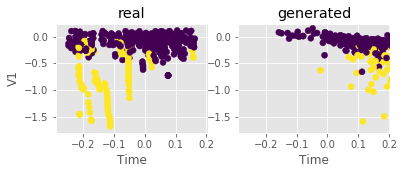

In [93]:
# Check using the same functions used during GAN training

print( CheckAccuracy( x, g_z, data_cols, label_cols, seed=0, with_class=with_class, data_dim=data_dim ) )

PlotData( x, g_z, data_cols, label_cols, seed=0, with_class=with_class, data_dim=data_dim )

In [94]:
# Now we can train and test an xgboost classifier on our generated data

real_samples = pd.DataFrame(x, columns=data_cols+label_cols)
test_samples = pd.DataFrame(g_z, columns=data_cols+label_cols)
real_samples['syn_label'] = 0
test_samples['syn_label'] = 1

training_fraction = 0.5
n_real, n_test = int(len(real_samples)*training_fraction), int(len(test_samples)*training_fraction)
train_df = pd.concat([real_samples[:n_real],test_samples[:n_test]],axis=0)
test_df = pd.concat([real_samples[n_real:],test_samples[n_test:]],axis=0)


X_col = test_df.columns[:-1]
y_col = test_df.columns[-1]
dtrain = xgb.DMatrix(train_df[X_col], train_df[y_col], feature_names=X_col)
dtest = xgb.DMatrix(test_df[X_col], feature_names=X_col)
y_true = test_df['syn_label']



xgb_params = {
    'max_depth': 4,
    'objective': 'binary:logistic',
    'random_state': 0,
    'eval_metric': 'auc', # allows for balanced or unbalanced classes 
}
xgb_test = xgb.train(xgb_params, dtrain, num_boost_round=10)

y_pred = np.round(xgb_test.predict(dtest))

print( '{:.2f}'.format(SimpleAccuracy(y_pred, y_true)) )

0.98


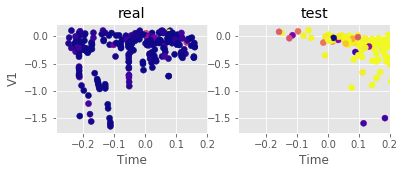

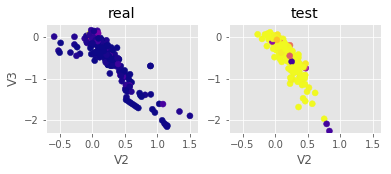

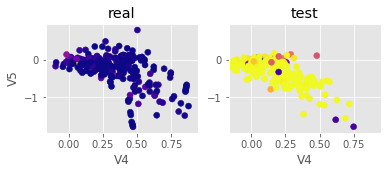

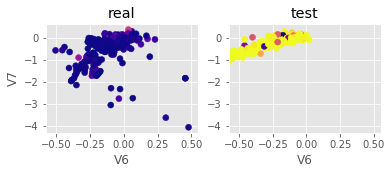

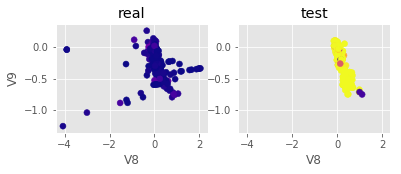

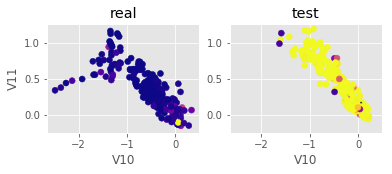

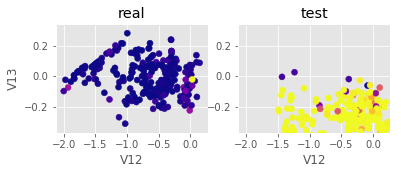

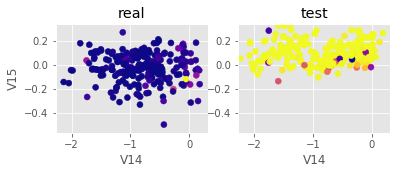

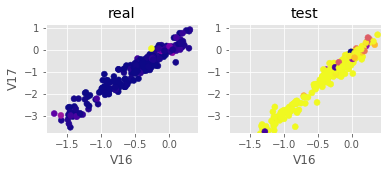

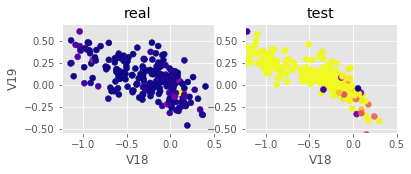

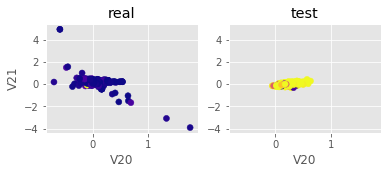

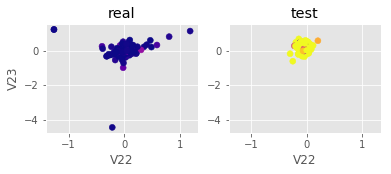

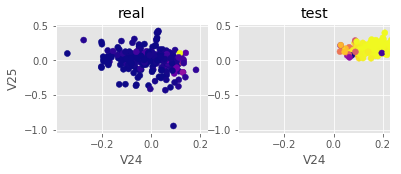

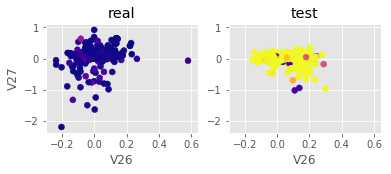

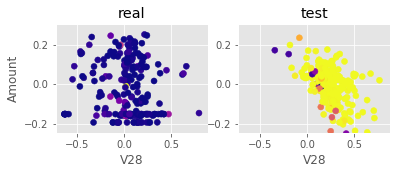

In [95]:

# Let's look at how the discrimnator scored real and generated data, visualized along every feature

y_pred0 = xgb_test.predict(dtest)

for i in range(0,len(X_col)-1, 2):

    f, axarr = plt.subplots(1, 2, figsize=(6,2) )

    axarr[0].scatter( test_df[:n_real][X_col[i]], test_df[:n_real][X_col[i+1]], c=y_pred0[:n_real], cmap='plasma'  )
    axarr[0].set_title('real')
    axarr[0].set_ylabel(X_col[i+1])

    axarr[1].scatter( test_df[n_real:][X_col[i]], test_df[n_real:][X_col[i+1]], c=y_pred0[n_real:], cmap='plasma'  )
    axarr[1].set_title('test')
    axarr[1].set_xlim(axarr[0].get_xlim()), axarr[1].set_ylim(axarr[0].get_ylim())

    for a in axarr:
        a.set_xlabel(X_col[i])

    plt.show()

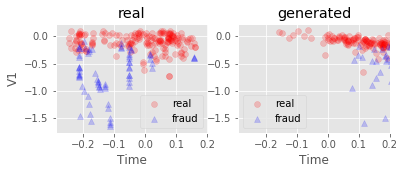

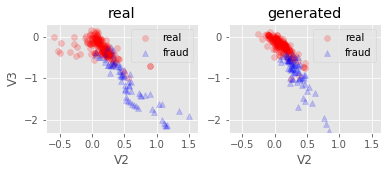

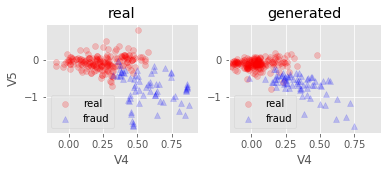

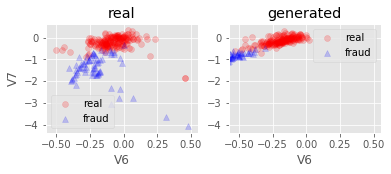

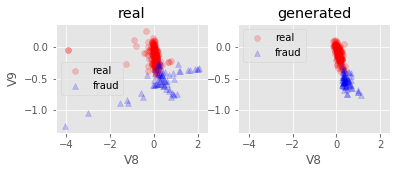

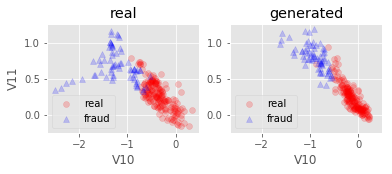

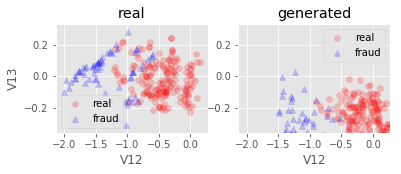

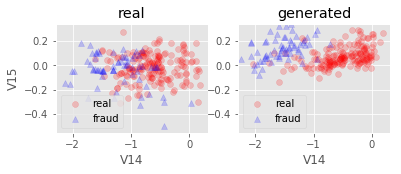

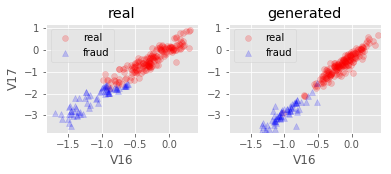

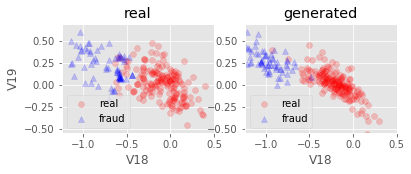

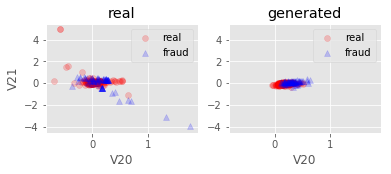

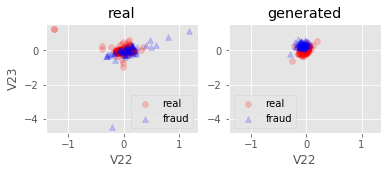

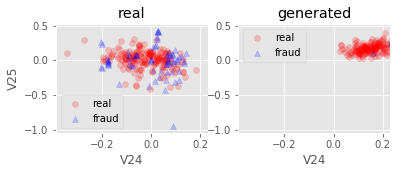

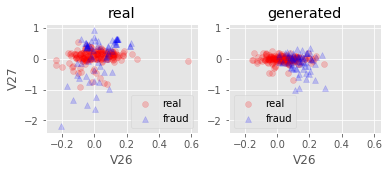

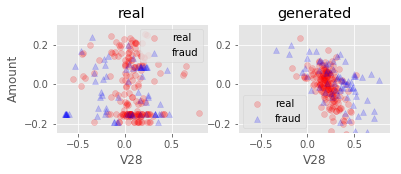

In [99]:

# Now we can compare the real and generated data by class, along every feature

colors = ['red','blue']
markers = ['o','^']
labels = ['real','fraud']

class_label = 'Class'

for i in range(0,len(X_col), 2):
    col1, col2 = i, i+1
    if i+1 >= len(X_col): continue
    
    f, axarr = plt.subplots(1, 2, figsize=(6,2) )
    for group, color, marker, label in zip( test_df[:n_real].groupby(class_label), colors, markers, labels ):
        axarr[0].scatter( group[1][X_col[col1]], group[1][X_col[col2]], label=label, c=color, marker=marker, alpha=0.2) 
    axarr[0].legend()
    axarr[0].set_title('real')
    axarr[0].set_ylabel(X_col[col2])

    for group, color, marker, label in zip( test_df[n_real:].groupby(class_label), colors, markers, labels ):
        axarr[1].scatter( group[1][X_col[col1]], group[1][X_col[col2]], label=label, c=color, marker=marker, alpha=0.2) 
    axarr[1].set_xlim(axarr[0].get_xlim()), axarr[1].set_ylim(axarr[0].get_ylim())
    axarr[1].legend()
    axarr[1].set_title('generated') ;

    for a in axarr:
        a.set_xlabel(X_col[col1])

    plt.show()

In [100]:

# Evaluate performance on validation set

SimpleMetrics(y_pred,y_true)

Confusion Matrix


,Pred 0,Pred 1
True 0,245,1
True 1,8,238


Accuracy : 0.9817073170731707


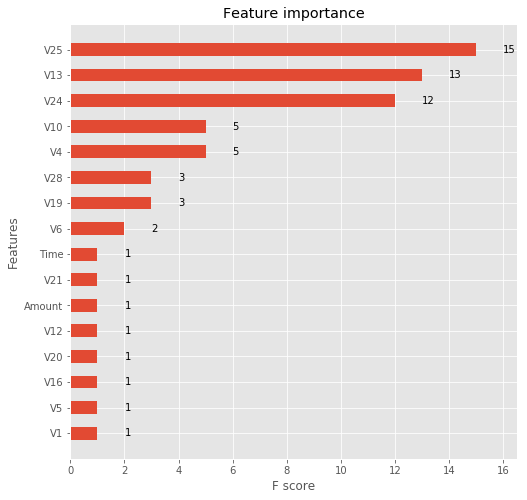

In [101]:

# Plot feature importances used for identifying generated data

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
xgb.plot_importance(xgb_test, max_num_features=20, height=0.5, ax=ax);

<a id="Compare GAN Output"><h1>Compare GAN Output</h1></a>




It may be best to restart the notebook, run the setup section, and then run this section


In [8]:

# Set up the training dataset

train = fraud_w_classes.copy().reset_index(drop=True) # fraud only with labels from classification

train = pd.get_dummies(train, columns=['Class'], prefix='Class', drop_first=True)
label_cols = [ i for i in train.columns if 'Class' in i ]
data_cols = [ i for i in train.columns if i not in label_cols ]
train[ data_cols ] = train[ data_cols ] / 10 # scale to random noise size, one less thing to learn
train_no_label = train[ data_cols ]

data_dim = len(data_cols)
label_dim = len(label_cols)

In [9]:
# Generate empty models

rand_dim = 32
base_n_count = 128
model_names = ['GAN','CGAN','WGAN','WCGAN']
with_classes = [False, True, False, True]
type0s = [None, None, 'Wasserstein', 'Wasserstein']

models = {}

for model_name, with_class, type0 in zip(model_names, with_classes, type0s ):

    if with_class:
        generator_model, discriminator_model, combined_model = \
            define_models_CGAN(rand_dim, data_dim, label_dim, base_n_count, type=type0)
    else:
         generator_model, discriminator_model, combined_model = \
            define_models_GAN(rand_dim, data_dim, base_n_count, type=type0)   
    
    models[model_name] = [ model_name, with_class, type0, generator_model ]

In [10]:

# Setup parameters

seed = 17
test_size = 492 # number of fraud cases

np.random.seed(seed)
z = np.random.normal(size=(test_size, rand_dim))
x = get_data_batch(train, test_size, seed=seed)
real_samples = pd.DataFrame(x, columns=data_cols+label_cols)
labels = x[:,-label_dim:]

# colors = ['C1','C9']
# colors = ['xkcd:plum', 'xkcd:navy']
colors = ['red','blue']
markers = ['o','^']
class_labels = ['Class 1','Class 2']

col1, col2 = 'V17', 'V10'

base_dir = 'cache lr mix base 128 act mix 171026/'


<a id="Fig5"><h1>Figure 5: Comparison of GAN outputs</h1></a><br>


0


/opt/conda/lib/python3.6/site-packages/Keras-2.0.4-py3.6.egg/keras/backend/tensorflow_backend.py:2289: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


100
200
500
1000
2000
5000


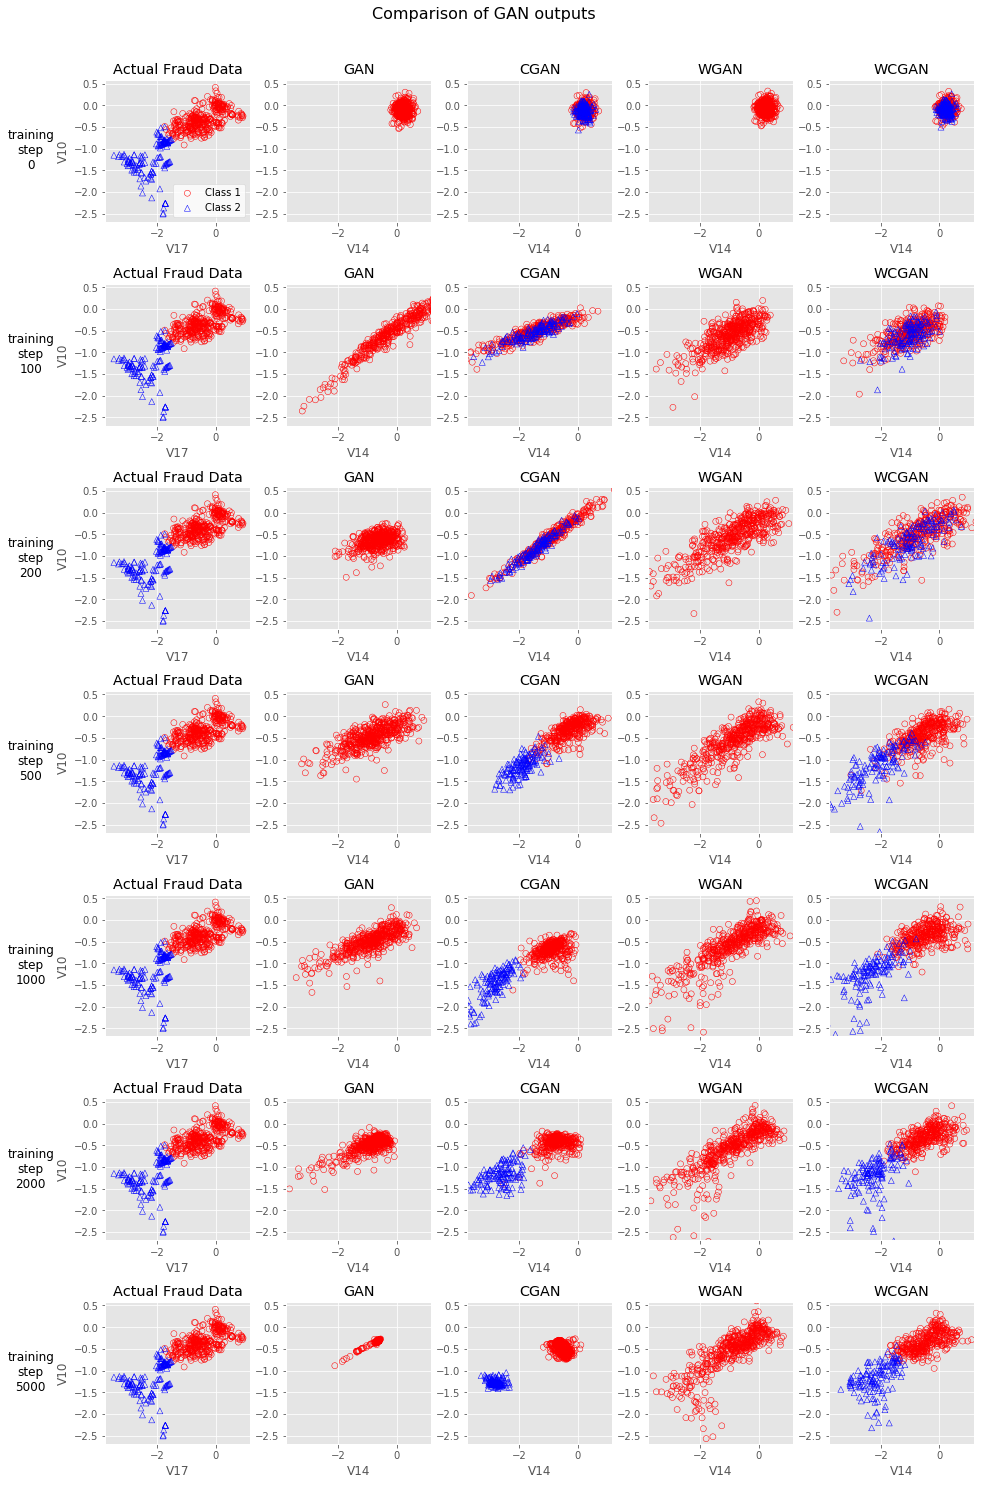

In [11]:


model_steps = [ 0, 100, 200, 500, 1000, 2000, 5000]
rows = len(model_steps)
columns = 5

axarr = [[]]*len(model_steps)

fig = plt.figure(figsize=(14,rows*3))

for model_step_ix, model_step in enumerate( model_steps ):
    print(model_step)
        
    axarr[model_step_ix] = plt.subplot(rows, columns, model_step_ix*columns + 1)
    
    for group, color, marker, label in zip( real_samples.groupby('Class_1'), colors, markers, class_labels ):
        plt.scatter( group[1][[col1]], group[1][[col2]], 
                         label=label, marker=marker, edgecolors=color, facecolors='none' )
    
    plt.title('Actual Fraud Data')
    plt.ylabel(col2) # Only add y label to left plot
    plt.xlabel(col1)
    xlims, ylims = axarr[model_step_ix].get_xlim(), axarr[model_step_ix].get_ylim()
        
    if model_step_ix == 0: 
        legend = plt.legend()
        legend.get_frame().set_facecolor('white')
    
    for i, model_name in enumerate( model_names[:] ):
        
        [ model_name, with_class, type0, generator_model ] = models[model_name]
        
        generator_model.load_weights( base_dir + model_name + '_generator_model_weights_step_'+str(model_step)+'.h5')

        ax = plt.subplot(rows, columns, model_step_ix*columns + 1 + (i+1) )
        
        if with_class:
            g_z = generator_model.predict([z, labels])
            gen_samples = pd.DataFrame(g_z, columns=data_cols+label_cols)
            for group, color, marker, label in zip( gen_samples.groupby('Class_1'), colors, markers, class_labels ):
                plt.scatter( group[1][[col1]], group[1][[col2]], 
                                 label=label, marker=marker, edgecolors=color, facecolors='none' )
        else:
            g_z = generator_model.predict(z)
            gen_samples = pd.DataFrame(g_z, columns=data_cols)
            plt.scatter( gen_samples[[col1]], gen_samples[[col2]], 
                             label=class_labels[0], marker=markers[0], edgecolors=colors[0], facecolors='none' )
        plt.title(model_name)   
        plt.xlabel(data_cols[0])
        ax.set_xlim(xlims), ax.set_ylim(ylims)


plt.suptitle('Comparison of GAN outputs', size=16)
plt.tight_layout(rect=[0.075,0,1,0.95])

# Adding text labels for traning steps
vpositions = np.array([ i._position.bounds[1] for i in axarr ])
vpositions += ((vpositions[0] - vpositions[1]) * 0.35 )
for model_step_ix, model_step in enumerate( model_steps ):
    fig.text( 0.05, vpositions[model_step_ix], 'training\nstep\n'+str(model_step), ha='center', va='center', size=12)



<a id="Generated Data Testing"><h1>Generated Data Testing</h1></a>



In [20]:

# Setup xgboost parameters

xgb_params = {
    'objective': 'binary:logistic',
    'random_state': 0,
    'eval_metric': 'auc', # auc, error

}


from sklearn.metrics import recall_score, precision_score, roc_auc_score

def recall(preds, dtrain):
    labels = dtrain.get_label()
    return 'recall',  recall_score(labels, np.round(preds))

def precision(preds, dtrain):
    labels = dtrain.get_label()
    return 'precision',  precision_score(labels, np.round(preds))

def roc_auc(preds, dtrain):
    labels = dtrain.get_label()
    return 'roc_auc',  roc_auc_score(labels, preds)


In [21]:

# Define model parameters

seed = 17
np.random.seed(seed)

data_dim = len(data_cols)
label_dim = len(label_cols)

base_dir = 'cache lr mix base 128 act mix 171026/'
rand_dim = 32
base_n_count = 128


In [22]:

# defined training set parameters

train_fraction = 0.7
X_col = data.columns[:-1]
y_col = data.columns[-1]

folds = 5


In [28]:

# Function to make cross folds with different amounts of an additional dataset added

def MakeCrossFolds( g_z_df=[] ):

    np.random.seed(0)

    train_real_set, test_real_set = [], []
    train_fraud_set, test_fraud_set = [], []

    real_samples = data.loc[ data.Class==0 ].copy()
    fraud_samples = data.loc[ data.Class==1 ].copy()


    n_temp_real = len(real_samples)

    for seed in range(folds):
        np.random.seed(seed)

        fraud_samples = fraud_samples.sample(len(fraud_samples), replace=False).reset_index(drop=True) # shuffle

        n_train_fraud = 100
        train_fraud_samples = fraud_samples[:n_train_fraud].reset_index(drop=True)


        n_test_fraud = 148 # 30% left out
        test_fraud_samples = fraud_samples[-n_test_fraud:].reset_index(drop=True)

        if len(g_z_df)==0: g_z_df = fraud_samples[n_train_fraud:-n_test_fraud] # for adding real data, if no generated
        n_g_z = len(g_z_df)
        train_fraud_samples = train_fraud_samples.append(g_z_df).reset_index(drop=True)

        real_samples = real_samples.sample(len(real_samples), replace=False).reset_index(drop=True) # shuffle
        temp_real_samples = real_samples[:n_temp_real]
        n_train_real = int(len(temp_real_samples) * train_fraction)

        train_real_samples = temp_real_samples[:n_train_real].reset_index(drop=True) # with margin
        test_real_samples = temp_real_samples[n_train_real:].reset_index(drop=True) # with margin

        train_real_set.append( train_real_samples )
        test_real_set.append( test_real_samples )
        train_fraud_set.append( train_fraud_samples )
        test_fraud_set.append( test_fraud_samples )

    print( n_train_fraud )
    for i in [ fraud_samples, g_z_df, train_fraud_samples, test_fraud_samples ]: print( len(i) )
    for i in [ real_samples, train_real_samples, test_real_samples ]: print( len(i) )
 
    
    return n_train_fraud, train_real_set, test_real_set, train_fraud_set, test_fraud_set


In [29]:


def Run_CV_Xgb(n_train_fraud, train_real_set, test_real_set, train_fraud_set, test_fraud_set):

    test_data=[]


    for i in np.logspace(0,np.log10((492-148)/100),num=5):

        print('# additional generated data tested: {}'.format (int(n_train_fraud*(i-1)) ) )
        for k in range(folds):

            train_df = pd.concat( 
                [ train_real_set[k], train_fraud_set[k][:int(n_train_fraud*i)] ],
                 axis=0,ignore_index=True).reset_index(drop=True)

            test_df = pd.concat( 
                [ test_real_set[k], test_fraud_set[k] ],
                axis=0,ignore_index=True).reset_index(drop=True)

            dtrain = xgb.DMatrix(train_df[X_col], train_df[y_col], feature_names=X_col)
            dtest = xgb.DMatrix(test_df[X_col], test_df[y_col], feature_names=X_col)

            results_dict = {}
            xgb_test = xgb.train(xgb_params, dtrain, num_boost_round=100, 
                                 verbose_eval=False, early_stopping_rounds=10, 
                                 evals=[(dtrain,'train'),(dtest,'test')],
                                 evals_result = results_dict )

            y_pred = xgb_test.predict(dtest, ntree_limit=xgb_test.best_iteration+1)
            y_true = test_df['Class'].values
            results = [k, i, xgb_test.best_iteration, recall( y_pred, dtest )[1], precision( y_pred, dtest )[1], roc_auc( y_pred, dtest )[1] ]

            test_data.append(results)
    test_data = pd.DataFrame(test_data, columns=['k', 'ratio','best','recall','precision','auc'])
    return test_data


In [ ]:
%%time

# Generate and test data with untrained model

generator_model, discriminator_model, combined_model = define_models_CGAN(rand_dim, data_dim, label_dim, base_n_count, type='Wasserstein')
generator_model.load_weights( base_dir + 'WCGAN_generator_model_weights_step_0.h5')

test_size = 492
x = get_data_batch(fraud_w_classes, test_size, seed=0)
z = np.random.normal(size=(test_size, rand_dim))
labels = x[:,-label_dim:]
g_z = generator_model.predict([z, labels])


# The labels for the generate data will all be 1, as they are supposed to be fraud data
g_z_df = pd.DataFrame( np.hstack( [g_z[:,:len(data_cols)], np.ones((len(g_z),1))] ), columns=data.columns )

n_train_fraud, train_real_set, test_real_set, train_fraud_set, test_fraud_set = MakeCrossFolds(g_z_df)
    
t_0 = Run_CV_Xgb(n_train_fraud, train_real_set, test_real_set, train_fraud_set, test_fraud_set)


In [114]:
%%time

# Generate and test data with trained model

generator_model, discriminator_model, combined_model = define_models_CGAN(rand_dim, data_dim, label_dim, base_n_count, type='Wasserstein')
generator_model.load_weights( base_dir + 'WCGAN_generator_model_weights_step_4800.h5')

test_size = 492
x = get_data_batch(fraud_w_classes, test_size, seed=0)
z = np.random.normal(size=(test_size, rand_dim))
labels = x[:,-label_dim:]
g_z = generator_model.predict([z, labels])



# The labels for the generate data will all be 1, as they are supposed to be fraud data
g_z_df = pd.DataFrame( np.hstack( [g_z[:,:len(data_cols)], np.ones((len(g_z),1))] ), columns=data.columns )

n_train_fraud, train_real_set, test_real_set, train_fraud_set, test_fraud_set = MakeCrossFolds(g_z_df)
    
t_4800 = Run_CV_Xgb(n_train_fraud, train_real_set, test_real_set, train_fraud_set, test_fraud_set)


/opt/conda/lib/python3.6/site-packages/Keras-2.0.4-py3.6.egg/keras/backend/tensorflow_backend.py:2289: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


100
492
492
592
148
284315
199020
85295
# additional generated data tested: 0
# additional generated data tested: 36
# additional generated data tested: 85
# additional generated data tested: 152
# additional generated data tested: 244
CPU times: user 18min 20s, sys: 5.59 s, total: 18min 26s
Wall time: 9min 20s


In [115]:
%%time

# Generate and test data with additional real data

n_train_fraud, train_real_set, test_real_set, train_fraud_set, test_fraud_set = MakeCrossFolds()
    
t_real = Run_CV_Xgb(n_train_fraud, train_real_set, test_real_set, train_fraud_set, test_fraud_set)


100
492
244
344
148
284315
199020
85295
# additional generated data tested: 0
# additional generated data tested: 36
# additional generated data tested: 85
# additional generated data tested: 152
# additional generated data tested: 244
CPU times: user 24min 3s, sys: 6.56 s, total: 24min 9s
Wall time: 12min 12s


In [30]:

# Reload the testing data

t_0 = pickle.load(open('cache/additional untrained generated fraud data test.pkl','rb'))
t_4800 = pickle.load(open('cache/additional generated fraud data test.pkl','rb'))
t_real = pickle.load(open('cache/additional real fraud data test.pkl','rb'))


<a id="Fig8"><h1>Figure 8: Effects of Additional Data on Fraud Detection</h1></a><br>



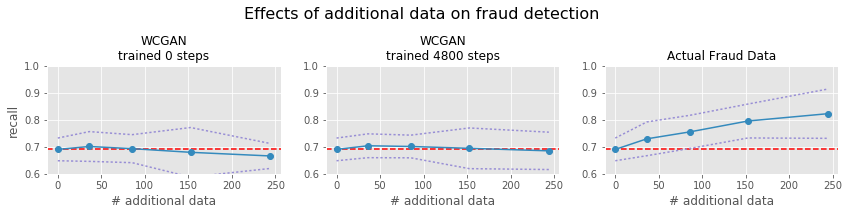

In [31]:

# Plot the testing data

labels = ['WCGAN\ntrained 0 steps','WCGAN\ntrained 4800 steps','Actual Fraud Data']

metric = 'recall'

plt.figure(figsize=(12,3))
for i, [label, test_data] in enumerate(zip(labels, [t_0, t_4800, t_real])):

    xs = [ n_train_fraud * (i[0]-1) for i in test_data.groupby('ratio') ]
    ys = test_data.groupby('ratio')[metric].mean().values
    stds = 2 * test_data.groupby('ratio')[metric].std().values

    plt.subplot(1,3,i+1)
    plt.axhline(ys[0],linestyle='--',color='red')
    plt.plot(xs,ys,c='C1',marker='o')
    plt.plot(xs,ys+stds,linestyle=':',c='C2')
    plt.plot(xs,ys-stds,linestyle=':',c='C2')
    if i==0: plt.ylabel(metric)
    plt.xlabel('# additional data')
    plt.title(label,size=12)

    plt.ylim([0.6,1.0])

plt.tight_layout(rect=[0,0,1,0.9])
plt.suptitle('Effects of additional data on fraud detection', size=16)

plt.show()

<a id="Summary"><h1>Summary of Training Data</h1></a>



In [32]:

# Load the saved loss data from each model

base_dir = 'cache lr mix base 128 act mix 171026/'

suffix = '_step_5000'

GAN_losses = pickle.load(open(base_dir + 'GAN_losses'+suffix+'.pkl','rb'))

CGAN_losses = pickle.load(open(base_dir + 'CGAN_losses'+suffix+'.pkl','rb'))
WGAN_losses = pickle.load(open(base_dir + 'WGAN_losses'+suffix+'.pkl','rb'))
WCGAN_losses = pickle.load(open(base_dir + 'WCGAN_losses'+suffix+'.pkl','rb'))

In [34]:

# Find best xgb scores overall and saved (every 100 steps)

data_ix = 3
data_sets = [ GAN_losses[data_ix], CGAN_losses[data_ix], WGAN_losses[data_ix], WCGAN_losses[data_ix]]
labels = [ 'GAN','CGAN','WGAN','WCGAN' ]

for label, data_set in zip( labels, data_sets ):
    best_step = list(data_set).index( np.array(data_set).min() ) * 10
    print( '{: <5} step {: <4}: {:.4f}'.format( label, best_step, np.array(data_set).min() ) )

    xgb100 = [ data_set[i] for i in range(0, len(data_set), 10) ]
    best_step = xgb100.index( min(xgb100) ) * 100
    print( '{: <5} step {: <4}: {:.4f}\n'.format( label, best_step, np.array(xgb100).min() ) )


GAN   step 760 : 0.7744
GAN   step 800 : 0.7886

CGAN  step 2020: 0.7500
CGAN  step 1800: 0.7825

WGAN  step 4580: 0.6768
WGAN  step 4800: 0.7215

WCGAN step 3570: 0.6789
WCGAN step 4800: 0.6951



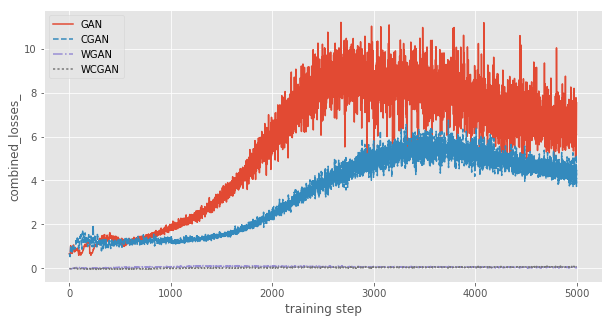

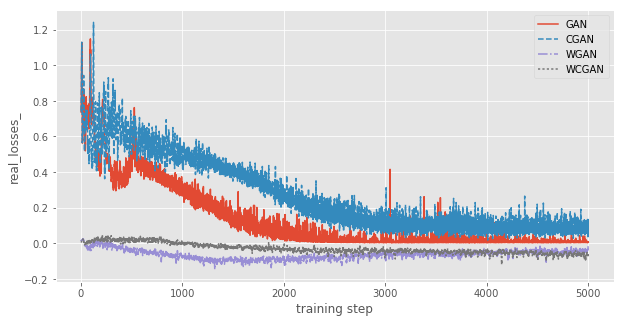

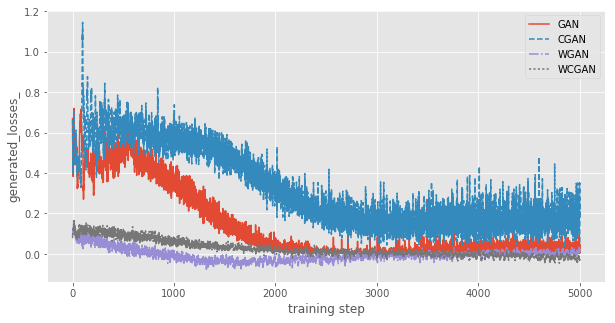

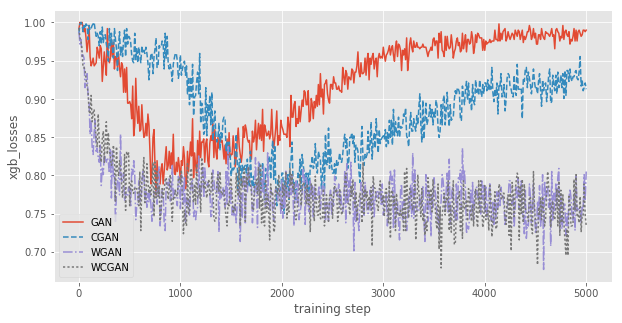

In [35]:

# Look at the unsmoothed losses

data_fields = ['combined_losses_', 'real_losses_', 'generated_losses_', 'xgb_losses']
sampling_intervals = [ 1, 1, 1, 10 ]
labels = [ 'GAN','CGAN','WGAN','WCGAN' ]
linestyles = ['-', '--', '-.', ':']

for data_ix in range(len(data_fields)):
    data_sets = [ GAN_losses[data_ix], CGAN_losses[data_ix], WGAN_losses[data_ix], WCGAN_losses[data_ix]]

    plt.figure(figsize=(10,5))
    for data, label, linestyle in zip(data_sets, labels, linestyles):
        plt.plot( np.array(range(0,len(data)))*sampling_intervals[data_ix],
                 data,
                 label=label, linestyle=linestyle )

    plt.ylabel(data_fields[data_ix])
    plt.xlabel('training step')
    plt.legend()
    plt.show()


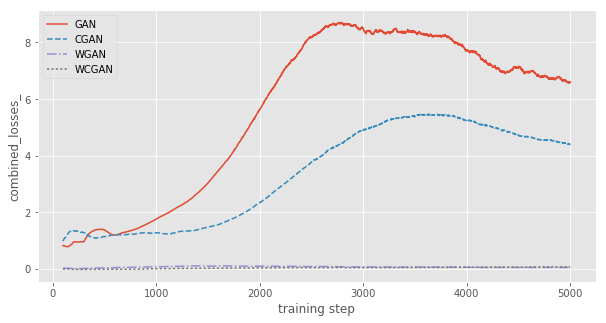

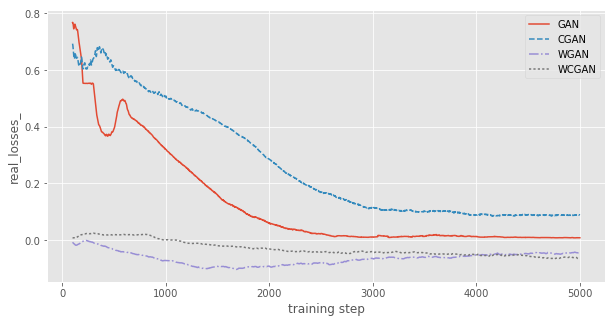

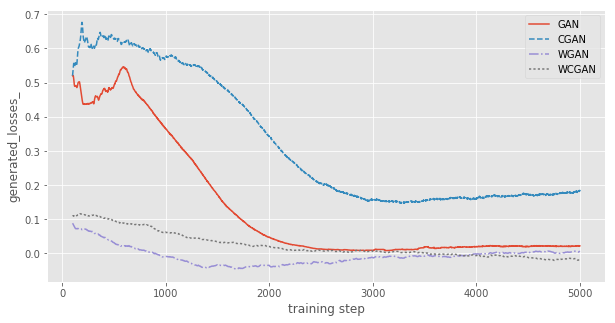

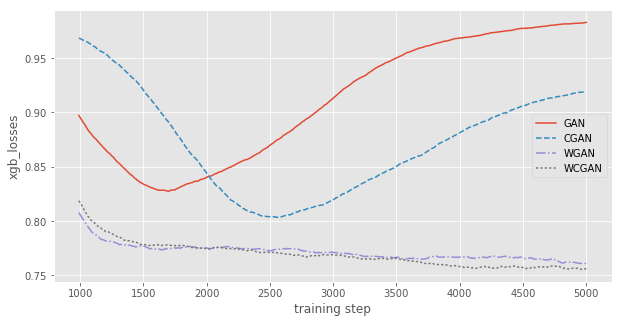

In [36]:

# Look at the smoothed losses

data_fields = ['combined_losses_', 'real_losses_', 'generated_losses_', 'xgb_losses']
sampling_intervals = [ 1, 1, 1, 10 ]
labels = [ 'GAN','CGAN','WGAN','WCGAN' ]
linestyles = ['-', '--', '-.', ':']

w = 100
for data_ix in range(len(data_fields)):
    data_sets = [ GAN_losses[data_ix], CGAN_losses[data_ix], WGAN_losses[data_ix], WCGAN_losses[data_ix]]

    plt.figure(figsize=(10,5))
    for data, label, linestyle in zip(data_sets, labels, linestyles):
        plt.plot( np.array(range(0,len(data)))*sampling_intervals[data_ix],
                 pd.DataFrame(data).rolling(w).mean(),
                 label=label, linestyle=linestyle )

    plt.ylabel(data_fields[data_ix])
    plt.xlabel('training step')
    plt.legend()
    plt.show()


<a id="Fig6"><h1>Figure 6: Accuracy of Generated Data Detection</h1></a><br>


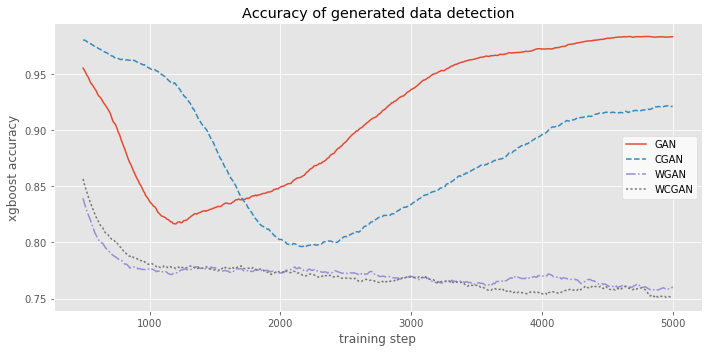

In [37]:

# Create a figure for the smoothed xgboost losses

data_fields = ['combined_losses_', 'real_losses_', 'generated_losses_', 'xgb_losses']
sampling_intervals = [ 1, 1, 1, 10 ]
labels = [ 'GAN','CGAN','WGAN','WCGAN' ]
linestyles = ['-', '--', '-.', ':']

w = 50
data_ix = 3

data_sets = [ GAN_losses[data_ix], CGAN_losses[data_ix], WGAN_losses[data_ix], WCGAN_losses[data_ix]]

plt.figure(figsize=(10,5))
for data, label, linestyle in zip(data_sets, labels, linestyles):
    plt.plot( np.array(range(0,len(data)))*sampling_intervals[data_ix],
             pd.DataFrame(data).rolling(w).mean(),
             label=label, linestyle=linestyle )

plt.ylabel(data_fields[data_ix])
plt.xlabel('training step')
legend = plt.legend() 
legend.get_frame().set_facecolor('white')

plt.title('Accuracy of generated data detection')
plt.ylabel('xgboost accuracy')
plt.tight_layout() ;
# plt.savefig('plots/GAN_accuracy.png')

<a id="Fig7"><h1>Figure 7: Differences in Critic Loss</h1></a><br>


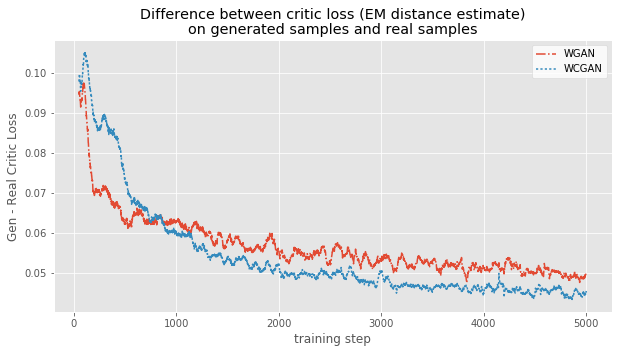

In [38]:

# Create a figure for the critic losses for the WGAN and WCGAN

w = 50

data_ix0 = 2
data_ix1 = 1
data_fields = ['combined_losses_', 'real_losses_', 'generated_losses_', 'xgb_losses']

i1, i2 = 2, 3
i2 += 1

labels = [ 'GAN','CGAN','WGAN','WCGAN' ][i1:i2]
data_sets0 = [ GAN_losses[data_ix0], CGAN_losses[data_ix0], WGAN_losses[data_ix0], WCGAN_losses[data_ix0]][i1:i2]
data_sets1 = [ GAN_losses[data_ix1], CGAN_losses[data_ix1], WGAN_losses[data_ix1], WCGAN_losses[data_ix1]][i1:i2]
linestyles = ['-', '--', '-.', ':'][i1:i2]

plt.figure(figsize=(10,5))
for data0, data1, label, linestyle in zip(data_sets0, data_sets1, labels, linestyles):
    plt.plot( range(0,len(data0)), 
             pd.DataFrame( np.array(data0)-np.array(data1) ).rolling(w).mean(),  
             label=label, linestyle=linestyle )
plt.title('Difference between critic loss (EM distance estimate)\non generated samples and real samples')
plt.xlabel('training step')
plt.ylabel('Gen - Real Critic Loss')
legend = plt.legend() 
legend.get_frame().set_facecolor('white')


<a id="DRAGAN"><h1>DRAGAN Training</h1></a>




This section is less developed, and may contain more errors that average


A number of errors in the wiseodd code?:
- xavier initializer
- calculation of gradient penalties



In [39]:
# Load engineered dataset from EDA section
data = pickle.load(open('data/' + 'credicard.engineered.pkl','rb'))

# Put columns in order of importance for xgboost fraud detection, from the xgboost section
sorted_cols = ['V14', 'V4', 'V10', 'V17', 'Time', 'V12', 'V26', 'Amount', 'V21', 'V8', 'V11', 'V7', 'V28', 'V19', 'V3', 'V22', 'V6', 'V20', 'V27', 'V16', 'V13', 'V25', 'V24', 'V18', 'V2', 'V1', 'V5', 'V15', 'V9', 'V23', 'Class']
data = data[ sorted_cols ].copy()

# data columns will be all other columns except class
data_cols = list(data.columns[ data.columns != 'Class' ])
data_dim = len(data_cols)
# label_cols = ['Class']
train = data.loc[ data.Class == 1, data_cols ].copy().reset_index(drop=True)
train[ data_cols ] = train[ data_cols ] / 10

with_class = False
show = True
data_dir = 'cache/'
cache_prefix = 'DRAGAN'
label_cols = []
log_interval = 100

z_dim = 32
X_dim = data_dim


In [40]:

# Load (and/or reload functions)

import GAN
import importlib
importlib.reload(GAN) # For reloading after making changes
from GAN import *


In [41]:

# Start with a clean tensorflow graph every time

tf.reset_default_graph()


In [42]:

# Define the DRAGAN network

mb_size = 128 # 128 # minibatch size
h_dim = 128 # 128 # hidden layer dim
lambda0 = 10
learning_rate = 1e-4 # 1e-4
global_seed = 0

[ D_solver, disc_cost, D_loss_real, D_loss_fake,
 X, X_p, z,
 G_solver, gen_cost, G_sample ] = \
    define_DRAGAN_network( X_dim=X_dim, h_dim=h_dim, z_dim=z_dim, learning_rate=learning_rate, mb_size=mb_size, seed=global_seed ) ;
    

In [43]:

# Set the tensorflow session, set seeds, create a saver function, and glance at the length of the operation set for the graph

sess = tf.Session()

np.random.seed(global_seed)
tf.set_random_seed(global_seed)
sess.graph.seed = global_seed

sess.run(tf.global_variables_initializer())

saver = tf.train.Saver( max_to_keep=10000 ) # 20 Mb+ for all, 1.5 Mb for thetas only
saver.save(sess, data_dir + cache_prefix ) 

combined_loss, disc_loss_generated, disc_loss_real, xgb_losses = [], [], [], []

best_xgb = 0.7

print( len( sess.graph.get_operations() ) )

1255


In [ ]:
%%time

# Now we train the DRAGAN
# We'll xgboost test it at intervals
# We'll also save the graph weights and losses at intervals as well

for it in range(0, 50000+1):
    
    X_mb = get_data_batch(train, mb_size, seed=it)
    X_mb_p = get_perturbed_batch(X_mb) # DRAGAN

    _, D_loss_curr, d_l_r, d_l_g = sess.run(
        [D_solver, disc_cost, D_loss_real, D_loss_fake],
        feed_dict={X: X_mb, X_p: X_mb_p, z: sample_z(mb_size, z_dim)}
    )

    _, G_loss_curr = sess.run(
        [G_solver, gen_cost],
        feed_dict={z: sample_z(mb_size, z_dim)}
    )

    disc_loss_real.append(d_l_r)
    disc_loss_generated.append(d_l_g)
    combined_loss.append(G_loss_curr)
    
    if it % 100 == 0:
        test_size = 492 # The total number of fraud cases
        x = get_data_batch(train, test_size, seed=it)
        g_z = sess.run(G_sample, feed_dict={z: sample_z(test_size, z_dim)})
        xgb_loss = CheckAccuracy( x, g_z, data_cols, label_cols, seed=0, with_class=with_class, data_dim=data_dim )
        xgb_losses.append(xgb_loss)
        if xgb_loss < best_xgb: 
            best_xgb = xgb_loss
            saver.save(sess, data_dir + cache_prefix, global_step=it, write_meta_graph=False )
            
    if it % log_interval == 0:
        print('Iter: {}; D loss: {:.4}; G_loss: {:.4}; xgb_loss: {:.4}'
              .format(it, D_loss_curr, G_loss_curr, xgb_loss))
        if show:
            PlotData( x, g_z, data_cols, label_cols, seed=0, with_class=with_class, data_dim=data_dim ) 
            
        saver.save(sess, data_dir + cache_prefix, global_step=it, write_meta_graph=False )

        pickle.dump([combined_loss, disc_loss_generated, disc_loss_real, xgb_losses], 
                        open( data_dir + cache_prefix + '_losses_step_{}.pkl'.format(it) ,'wb'))
    

In [ ]:
%%time

# for continued training

for it in range(50001, 100001):
    
    X_mb = get_data_batch(train, mb_size, seed=it)
    X_mb_p = get_perturbed_batch(X_mb) # DRAGAN

    _, D_loss_curr, d_l_r, d_l_g = sess.run(
        [D_solver, disc_cost, D_loss_real, D_loss_fake],
        feed_dict={X: X_mb, X_p: X_mb_p, z: sample_z(mb_size, z_dim)}
    )

    _, G_loss_curr = sess.run(
        [G_solver, gen_cost],
        feed_dict={z: sample_z(mb_size, z_dim)}
    )

    disc_loss_real.append(d_l_r)
    disc_loss_generated.append(d_l_g)
    combined_loss.append(G_loss_curr)
    
    if it % 100 == 0:
        test_size = 492 # mb_size
        x = get_data_batch(train, test_size, seed=it)
        g_z = sess.run(G_sample, feed_dict={z: sample_z(test_size, z_dim)})
        xgb_loss = CheckAccuracy( x, g_z, data_cols, label_cols, seed=0, with_class=with_class, data_dim=data_dim )
        xgb_losses.append(xgb_loss)
            
    if it % log_interval == 0:
        print('Iter: {}; D loss: {:.4}; G_loss: {:.4}; xgb_loss: {:.4}'
              .format(it, D_loss_curr, G_loss_curr, xgb_loss))
        if show:
            PlotData( x, g_z, data_cols, label_cols, seed=0, with_class=with_class, data_dim=data_dim ) 
            
        saver.save(sess, data_dir + cache_prefix, global_step=it, write_meta_graph=False )

        pickle.dump([combined_loss, disc_loss_generated, disc_loss_real, xgb_losses], 
                        open( data_dir + cache_prefix + '_losses_step_{}.pkl'.format(it) ,'wb'))
    

In [49]:
# Or we can just define the network like we did before and just load the weights
# That way we already have all the operations defined

# So, to load stored graph, with operations defined locally:

tf.reset_default_graph()
sess = tf.Session()
print( len( sess.graph.get_operations() ) )

[ D_solver, disc_cost, D_loss_real, D_loss_fake,
 X, X_p, z,
 G_solver, gen_cost, G_sample ] = \
    define_DRAGAN_network( X_dim=X_dim, h_dim=h_dim, z_dim=z_dim, learning_rate=learning_rate, mb_size=mb_size, seed=global_seed ) ;

sess = tf.Session()

np.random.seed(global_seed)
tf.set_random_seed(global_seed)
sess.graph.seed = global_seed

sess.run(tf.global_variables_initializer())

saver = tf.train.Saver( max_to_keep=10000 ) # 20 Mb+ for all, 1.5 Mb for thetas only

print( len( sess.graph.get_operations() ) )


0
1255


In [50]:
# To load saved weights and test

saver.restore(sess, data_dir + cache_prefix + '-45400' )

print( len( sess.graph.get_operations() ) )

g_z = sess.run(G_sample, feed_dict={z: sample_z(test_size, z_dim)})
# g_z


INFO:tensorflow:Restoring parameters from cache/DRAGAN-45400
1255


array([[-1.69314194,  0.43251818, -0.88453162, ..., -0.0634074 ,
        -0.51207197, -0.1945249 ],
       [-0.44295561,  0.48945382, -0.72600222, ..., -0.02171172,
        -0.34944904, -0.37514728],
       [-0.15479982,  0.27314556,  0.33123285, ...,  0.22336292,
        -0.01666688,  0.11030016],
       ..., 
       [-1.15185869,  0.36319119, -0.7255854 , ..., -0.18840903,
        -0.18972759, -0.09558221],
       [-0.14709084,  0.06894944,  0.10532488, ..., -0.19609131,
         0.3188636 ,  0.41346157],
       [-0.77093989,  0.62392265, -1.78073943, ..., -0.09683804,
        -0.95833415,  0.19716872]], dtype=float32)

In [51]:
# %%time

# We can test the generated data using the functions from the 'GAN Data Testing' Section
# You'll need to load the functions from that section for this to work

# The labels for the generate data will all be 1, as they are supposed to be fraud data
g_z_df = pd.DataFrame( np.hstack( [g_z[:,:len(data_cols)], np.ones((len(g_z),1))] ), columns=data.columns )

n_train_fraud, train_real_set, test_real_set, train_fraud_set, test_fraud_set = MakeCrossFolds(g_z_df)
    
t_DRAGAN = Run_CV_Xgb(n_train_fraud, train_real_set, test_real_set, train_fraud_set, test_fraud_set)


100
492
492
592
148
284315
199020
85295
# additional generated data tested: 0
# additional generated data tested: 36
# additional generated data tested: 85
# additional generated data tested: 152
# additional generated data tested: 244


In [57]:
# Looks like still no increase in recall

t_DRAGAN.groupby('ratio')[['recall']].aggregate(['mean','std'])

recall          
              mean       std
ratio                       
1.000000  0.690541  0.021044
1.361882  0.717568  0.029990
1.854724  0.710811  0.031110
2.525916  0.710811  0.021044
3.440000  0.700000  0.029297

In [44]:

# To load saved losses

prefix = 'DRAGAN'

[combined_loss, disc_loss_generated, disc_loss_real, xgb_losses] = pickle.load(open(data_dir+prefix+'_losses_step_100000.pkl','rb'))


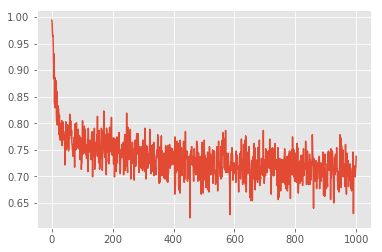

In [45]:

# Let's look at the xgboost losses

w = 1
plt.plot( pd.DataFrame(xgb_losses[:]).rolling(w).mean() ) ;


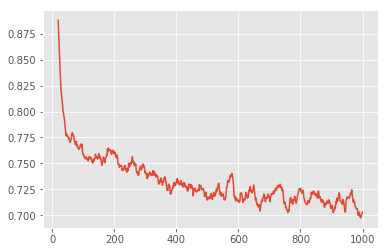

In [46]:
# Let's look at the smoothed xgboost losses

w = 20
plt.plot( pd.DataFrame(xgb_losses[:]).rolling(w).mean() ) ;


In [47]:

# Let's find the best xgboost loss

best_step = xgb_losses.index( np.array(xgb_losses).min() ) * 100
print( best_step, np.array(xgb_losses).min() )

xgb100 = [ xgb_losses[i] for i in range(0, len(xgb_losses), 1) ]
best_step = xgb100.index( min(xgb100) ) * log_interval
print( best_step, min(xgb100) )

45400 0.621951219512
45400 0.621951219512


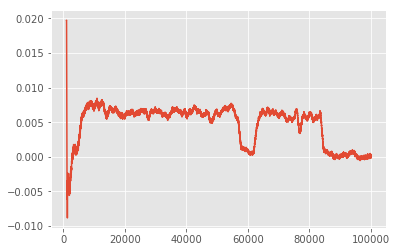

In [48]:



w = 1000
plt.plot( pd.DataFrame(disc_loss_real[:]).rolling(w).mean() - pd.DataFrame(disc_loss_generated[:]).rolling(w).mean() ) ;
